In [29]:
# from comet_ml import Experiment
# experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

In [30]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.utils import np_utils 

In [31]:
import os
import fnmatch

import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

import itertools

import scipy.stats as stats

## Load Data

In [32]:
train_path = "I:\\Honours-Project\\data\\heparin\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\heparin\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\heparin\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\heparin\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\heparin\\agg\\"

csv = "I:\\Honours-Project\\data\\heparin\\agg\\ids.csv"

In [33]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)
df = df[~df['name'].str.contains("_flipped")]

In [34]:
df.head()

,name,date,flow_rate,source,peak_val,num_peaks,eccentricity,euler_number,extent,inertia_tensor,mean_intensity,moments,orientation,perimeter,volume,area,sd,num_local_peaks
45,45,2018.6.1,3600,1.61 s.tifheightmap.mat,6.155849,2,0.983176,1,0.346052,[[ 313.3951565 -812.5919142 ]\r\n [-812.59191...,3.460561,[[6.53000000e+03 1.00758400e+06 1.92282624e+08...,-1.422658,613.244733,22597.463653,6530,1.802397,7
97,97,2018.6.6,1800,13.93 s.tifheightmap.mat,3.461202,1,0.914540,1,0.362902,[[477.44171386 253.57725385]\r\n [253.57725385...,1.807722,[[2.38100000e+03 9.53110000e+04 4.48151900e+06...,0.599609,277.320851,4304.186791,2381,0.959378,3
25,25,2018.5.15,7200,3.60 s.tifheightmap.mat,8.341607,1,0.886497,1,0.593233,[[ 297.23159249 200.67344114]\r\n [ 200.67344...,3.385146,[[6.31200000e+03 4.58356000e+05 4.04013780e+07...,1.345672,391.404112,21367.040517,6312,1.967472,10
137,137,2018.6.6,7200,32.13 s.tifheightmap.mat,4.164564,1,0.878233,1,0.631313,[[ 61.677056 -37.8257984 ]\r\n [-37.8257984 ...,1.996748,[[1.25000000e+03 4.20960000e+04 1.69873800e+06...,-1.353748,161.195959,2495.935316,1250,1.245480,2
21,21,2018.5.15,7200,11.30 s.tifheightmap.mat,5.960682,1,0.932630,1,0.477784,[[ 143.06983854 -85.33686817]\r\n [ -85.33686...,2.432540,[[3.39800000e+03 2.13094000e+05 1.68568200e+07...,-1.475539,340.735065,8265.772073,3398,1.474307,5


### Downsample to balanced classes

In [35]:
ds_count = min(df.groupby('date').size())
ds_flow = df.groupby('date').size().idxmin()

samples = pd.concat([df[df['date']==i].sample(n=ds_count) 
                     for i in df.date.unique()],ignore_index=True)

df = samples.sample(frac=1)

print(samples.groupby('date').size())

date
2018.5.15    27
2018.6.1     27
2018.6.5     27
2018.6.6     27
dtype: int64


### Drop columns which we aren't using as features

In [36]:
def drop_cols(df):
    return df.drop(columns=['name','date','flow_rate','source','moments',
                            'inertia_tensor','euler_number','num_peaks']).as_matrix()

In [37]:
df['log_volume'] = df['volume'].apply(np.log)

x = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical  features
mat = x.drop(columns=['euler_number', 'num_peaks'])

x = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

### Split data into balanced test and training sets

In [38]:
x_test = pd.concat([df[df['date']==i].sample(n=10) for i in df.date.unique()],ignore_index=True)
y_test = x_test['date'].values

x_train = pd.concat([df, x_test, x_test]).drop_duplicates(keep=False)
y_train = x_train['date'].values

x_test = drop_cols(x_test)
x_train = drop_cols(x_train)

print(x_train.shape)
print(x_test.shape)

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

(68, 11)
(40, 11)


## Run Logistic Regression

In [39]:
batch_size = 16
nb_classes = 4
nb_epoch = 30

lmda = 0.001

In [40]:
input_dim = x_train.shape[1]

In [41]:
y_train[y_train == '2018.5.15'] = 0
y_train[y_train == '2018.6.1'] = 1
y_train[y_train == '2018.6.5'] = 2
y_train[y_train == '2018.6.6'] = 3

y_test[y_test == '2018.5.15'] = 0
y_test[y_test == '2018.6.1'] = 1
y_test[y_test == '2018.6.5'] = 2
y_test[y_test == '2018.6.6'] = 3

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [42]:
def build_logistic_model(input_dim, output_dim, lmda):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,
                    kernel_regularizer=l2(lmda),
                    activation='softmax'))
    
    return model

def compile_model(input_dim, output_dim, lmda, optimizer):
    model = build_logistic_model(input_dim,output_dim,lmda)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [43]:
model = None
model = build_logistic_model(input_dim, nb_classes,lmda)

In [44]:
y_train.shape

(68, 4)

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 4)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [46]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 68 samples, validate on 40 samples
Epoch 1/30
68/68 [==============================] - 1s 18ms/step - loss: 2.1716 - acc: 0.2353 - val_loss: 2.0826 - val_acc: 0.2500
Epoch 2/30
68/68 [==============================] - 0s 514us/step - loss: 2.1282 - acc: 0.2353 - val_loss: 2.0556 - val_acc: 0.2500
Epoch 3/30
68/68 [==============================] - 0s 485us/step - loss: 2.0901 - acc: 0.2353 - val_loss: 2.0203 - val_acc: 0.2500
Epoch 4/30
68/68 [==============================] - 0s 514us/step - loss: 2.0450 - acc: 0.2353 - val_loss: 1.9762 - val_acc: 0.2500
Epoch 5/30
68/68 [==============================] - 0s 544us/step - loss: 1.9914 - acc: 0.2206 - val_loss: 1.9499 - val_acc: 0.2500
Epoch 6/30
68/68 [==============================] - 0s 470us/step - loss: 1.9511 - acc: 0.2353 - val_loss: 1.9279 - val_acc: 0.2500
Epoch 7/30
68/68 [==============================] - 0s 544us/step - loss: 1.9169 - acc: 0.2353 - val_loss: 1.9001 - val_acc: 0.2500
Epoch 8/30
68/68 [===============

In [47]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.570954966545105
Test accuracy: 0.275


## Confusion Matrix

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

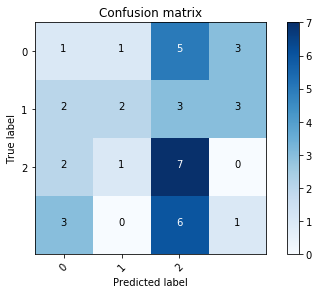

In [49]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## LR With Cross Validation

In [50]:
batch_size = 8
nb_classes = 4
lmda = 0.01

nb_epoch = 10

In [51]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=2)
    return score[1]

In [52]:
n_folds = 10

labels = df['date'].values
data = x

labels[labels == '2018.5.15'] = 0
labels[labels == '2018.6.1'] = 1
labels[labels == '2018.6.5'] = 2
labels[labels == '2018.6.6'] = 3

one_hot = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(df['date'].values, n_folds=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

for i, (train, test) in enumerate(skf):
    print("Running Fold", i+1, "/", n_folds)
    model = None # Clearing the NN.
    model = build_logistic_model(input_dim, nb_classes, lmda)
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
    
    x_train = (data[train]-mean)/std
    x_test = (data[test] - mean)/std        
    
    avg_acc += train_and_evaluate_model(model, x_train, one_hot[train], x_test, one_hot[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(one_hot[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10
Train on 96 samples, validate on 12 samples
Epoch 1/10
96/96 [==============================] - 1s 13ms/step - loss: 1.8463 - acc: 0.2812 - val_loss: 1.4017 - val_acc: 0.4167
Epoch 2/10
96/96 [==============================] - 0s 510us/step - loss: 1.7793 - acc: 0.2812 - val_loss: 1.4021 - val_acc: 0.4167
Epoch 3/10
96/96 [==============================] - 0s 573us/step - loss: 1.7224 - acc: 0.2917 - val_loss: 1.4086 - val_acc: 0.4167
Epoch 4/10
96/96 [==============================] - 0s 510us/step - loss: 1.6761 - acc: 0.2917 - val_loss: 1.4185 - val_acc: 0.4167
Epoch 5/10
96/96 [==============================] - 0s 489us/step - loss: 1.6337 - acc: 0.2917 - val_loss: 1.4313 - val_acc: 0.4167
Epoch 6/10
96/96 [==============================] - 0s 531us/step - loss: 1.5998 - acc: 0.2812 - val_loss: 1.4462 - val_acc: 0.4167
Epoch 7/10
96/96 [==============================] - 0s 614us/step - loss: 1.5706 - acc: 0.2812 - val_loss: 1.4617 - val_acc: 0.5000
Epoch 8/10
96

96/96 [==============================] - 0s 489us/step - loss: 1.5486 - acc: 0.2812 - val_loss: 1.2001 - val_acc: 0.4167
Running Fold 7 / 10
Train on 96 samples, validate on 12 samples
Epoch 1/10
96/96 [==============================] - 1s 14ms/step - loss: 2.1748 - acc: 0.2083 - val_loss: 1.5963 - val_acc: 0.3333
Epoch 2/10
96/96 [==============================] - 0s 479us/step - loss: 2.0671 - acc: 0.2083 - val_loss: 1.5493 - val_acc: 0.3333
Epoch 3/10
96/96 [==============================] - 0s 593us/step - loss: 1.9704 - acc: 0.2500 - val_loss: 1.5078 - val_acc: 0.3333
Epoch 4/10
96/96 [==============================] - 0s 437us/step - loss: 1.8834 - acc: 0.2396 - val_loss: 1.4712 - val_acc: 0.3333
Epoch 5/10
96/96 [==============================] - ETA: 0s - loss: 1.8228 - acc: 0.125 - 0s 552us/step - loss: 1.8070 - acc: 0.2396 - val_loss: 1.4398 - val_acc: 0.3333
Epoch 6/10
96/96 [==============================] - 0s 500us/step - loss: 1.7407 - acc: 0.2604 - val_loss: 1.4132 - va

In [53]:
print("Average Accuracy: ", avg_acc/n_folds)

Average Accuracy:  0.28333333432674407


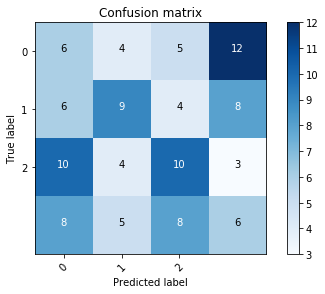

In [54]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## Grid Search on Hyper-parameters

Note: Test dataset size is wrong?

Also: This takes a while!

In [55]:
model = KerasClassifier(build_fn=compile_model,input_dim=input_dim, output_dim=nb_classes, optimizer='sgd')

param_grid = dict(epochs=[10,20,30], batch_size=[1,4,8,16,32], lmda=[0.001,0.005,0.01,0.05,0.1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=2)
grid_result = grid.fit(data, one_hot)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
97/97 [==============================] - 1s 14ms/step - loss: 11.9696 - acc: 0.2577
Epoch 2/10
97/97 [==============================] - 0s 1ms/step - loss: 11.9696 - acc: 0.2577
Epoch 3/10
97/97 [==============================] - 0s 1ms/step - loss: 11.9696 - acc: 0.2577
Epoch 4/10
97/97 [==============================] - 0s 1ms/step - loss: 11.9696 - acc: 0.2577
Epoch 5/10
97/97 [==============================] - 0s 1ms/step - loss: 11.9696 - acc: 0.2577
Epoch 6/10
97/97 [==============================] - 0s 1ms/step - loss: 11.9696 - acc: 0.2577
Epoch 7/10
97/97 [==============================] - 0s 1ms/step - loss: 11.9696 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 938us/step - loss: 11.9696 - acc: 0.2577
Epoch 9/10
97/97 [==============================] - 0s 835us/step - loss: 11.9696 - acc: 0.2577
Epoch 10/10
97/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


97/97 [==============================] - 1s 14ms/step - loss: 11.8027 - acc: 0.2680
Epoch 2/10
97/97 [==============================] - 0s 1ms/step - loss: 11.8027 - acc: 0.2680
Epoch 3/10
97/97 [==============================] - 0s 1ms/step - loss: 11.8027 - acc: 0.2680
Epoch 4/10
97/97 [==============================] - 0s 1ms/step - loss: 11.8026 - acc: 0.2680
Epoch 5/10
97/97 [==============================] - 0s 1ms/step - loss: 11.8026 - acc: 0.2680
Epoch 6/10
97/97 [==============================] - 0s 1ms/step - loss: 11.8026 - acc: 0.2680
Epoch 7/10
97/97 [==============================] - 0s 927us/step - loss: 11.8026 - acc: 0.2680
Epoch 8/10
97/97 [==============================] - 0s 958us/step - loss: 11.8026 - acc: 0.2680
Epoch 9/10
97/97 [==============================] - 0s 865us/step - loss: 11.8026 - acc: 0.2680
Epoch 10/10
97/97 [==============================] - 0s 443us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total=   3.0s
[CV] batch_size=4, e

97/97 [==============================] - 0s 474us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total=   3.0s
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
98/98 [==============================] - 2s 15ms/step - loss: 11.3535 - acc: 0.2959
Epoch 2/10
98/98 [==============================] - 0s 1ms/step - loss: 11.3535 - acc: 0.2959
Epoch 3/10
98/98 [==============================] - 0s 1ms/step - loss: 11.3535 - acc: 0.2959
Epoch 4/10
98/98 [==============================] - 0s 999us/step - loss: 11.3535 - acc: 0.2959
Epoch 5/10
98/98 [==============================] - 0s 1ms/step - loss: 11.3535 - acc: 0.2959
Epoch 6/10
98/98 [==============================] - 0s 1ms/step - loss: 11.3535 - acc: 0.2959
Epoch 7/10
98/98 [==============================] - 0s 877us/step - loss: 11.3535 - acc: 0.2959
Epoch 8/10
98/98 [==============================] - 0s 999us/step - loss: 11.3535 - acc: 0.2959
Epoch 9/10
98/98 [==========================

97/97 [==============================] - 0s 876us/step - loss: 12.3192 - acc: 0.2371
Epoch 8/10
97/97 [==============================] - 0s 1ms/step - loss: 12.3191 - acc: 0.2371
Epoch 9/10
97/97 [==============================] - 0s 1ms/step - loss: 12.3190 - acc: 0.2371
Epoch 10/10
97/97 [==============================] - 0s 453us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.005, total=   3.3s
[CV] batch_size=4, epochs=10, lmda=0.005 .............................
Epoch 1/10
97/97 [==============================] - 2s 16ms/step - loss: 12.1515 - acc: 0.2474
Epoch 2/10
97/97 [==============================] - 0s 917us/step - loss: 12.1513 - acc: 0.2474
Epoch 3/10
97/97 [==============================] - 0s 866us/step - loss: 12.1512 - acc: 0.2474
Epoch 4/10
97/97 [==============================] - 0s 896us/step - loss: 12.1511 - acc: 0.2474
Epoch 5/10
97/97 [==============================] - 0s 896us/step - loss: 12.1510 - acc: 0.2474
Epoch 6/10
97/97 [=====================

97/97 [==============================] - 0s 1ms/step - loss: 12.0298 - acc: 0.2577
Epoch 5/10
97/97 [==============================] - 0s 1ms/step - loss: 12.0291 - acc: 0.2577
Epoch 6/10
97/97 [==============================] - 0s 958us/step - loss: 12.0285 - acc: 0.2577
Epoch 7/10
97/97 [==============================] - 0s 1ms/step - loss: 12.0278 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 1ms/step - loss: 12.0272 - acc: 0.2577
Epoch 9/10
97/97 [==============================] - 0s 938us/step - loss: 12.0266 - acc: 0.2577
Epoch 10/10
97/97 [==============================] - 0s 474us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.01, total=   3.4s
[CV] batch_size=4, epochs=10, lmda=0.01 ..............................
Epoch 1/10
97/97 [==============================] - 2s 18ms/step - loss: 12.0126 - acc: 0.2577
Epoch 2/10
97/97 [==============================] - 0s 938us/step - loss: 12.4661 - acc: 0.2371
Epoch 3/10
97/97 [=========================

98/98 [==============================] - 2s 19ms/step - loss: 12.0642 - acc: 0.2551
Epoch 2/10
98/98 [==============================] - 0s 959us/step - loss: 12.0636 - acc: 0.2551
Epoch 3/10
98/98 [==============================] - 0s 959us/step - loss: 12.0631 - acc: 0.2551
Epoch 4/10
98/98 [==============================] - 0s 989us/step - loss: 12.0625 - acc: 0.2551
Epoch 5/10
98/98 [==============================] - 0s 1ms/step - loss: 12.0619 - acc: 0.2551
Epoch 6/10
98/98 [==============================] - 0s 948us/step - loss: 12.0614 - acc: 0.2551
Epoch 7/10
98/98 [==============================] - 0s 999us/step - loss: 12.0608 - acc: 0.2551
Epoch 8/10
98/98 [==============================] - 0s 1ms/step - loss: 12.0603 - acc: 0.2551
Epoch 9/10
98/98 [==============================] - 0s 948us/step - loss: 12.0598 - acc: 0.2551
Epoch 10/10
98/98 [==============================] - 0s 459us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.01, total=   3.6s
[CV] batch_siz

97/97 [==============================] - 0s 546us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.05, total=   3.8s
[CV] batch_size=4, epochs=10, lmda=0.05 ..............................
Epoch 1/10
97/97 [==============================] - 2s 21ms/step - loss: 12.2534 - acc: 0.2577
Epoch 2/10
97/97 [==============================] - 0s 1ms/step - loss: 12.2397 - acc: 0.2577
Epoch 3/10
97/97 [==============================] - 0s 1ms/step - loss: 12.2262 - acc: 0.2577
Epoch 4/10
97/97 [==============================] - 0s 834us/step - loss: 12.2134 - acc: 0.2577
Epoch 5/10
97/97 [==============================] - 0s 1ms/step - loss: 12.2012 - acc: 0.2577
Epoch 6/10
97/97 [==============================] - 0s 958us/step - loss: 12.1897 - acc: 0.2577
Epoch 7/10
97/97 [==============================] - 0s 917us/step - loss: 12.1787 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 876us/step - loss: 12.1682 - acc: 0.2577
Epoch 9/10
97/97 [========================

97/97 [==============================] - 0s 927us/step - loss: 12.2549 - acc: 0.2577
Epoch 9/10
97/97 [==============================] - 0s 896us/step - loss: 12.2272 - acc: 0.2577
Epoch 10/10
97/97 [==============================] - 0s 422us/step
[CV] ................ batch_size=4, epochs=10, lmda=0.1, total=   3.8s
[CV] batch_size=4, epochs=10, lmda=0.1 ...............................
Epoch 1/10
97/97 [==============================] - 2s 22ms/step - loss: 12.8489 - acc: 0.2371
Epoch 2/10
97/97 [==============================] - 0s 1ms/step - loss: 12.7962 - acc: 0.2371
Epoch 3/10
97/97 [==============================] - 0s 1ms/step - loss: 12.7486 - acc: 0.2371
Epoch 4/10
97/97 [==============================] - 0s 948us/step - loss: 12.7055 - acc: 0.2371
Epoch 5/10
97/97 [==============================] - 0s 886us/step - loss: 12.6666 - acc: 0.2371
Epoch 6/10
97/97 [==============================] - 0s 979us/step - loss: 12.6313 - acc: 0.2371
Epoch 7/10
97/97 [=====================

98/98 [==============================] - 0s 1ms/step - loss: 12.4175 - acc: 0.2551
Epoch 5/10
98/98 [==============================] - 0s 1ms/step - loss: 12.3783 - acc: 0.2551
Epoch 6/10
98/98 [==============================] - 0s 1ms/step - loss: 12.3429 - acc: 0.2551
Epoch 7/10
98/98 [==============================] - 0s 1ms/step - loss: 12.3109 - acc: 0.2551
Epoch 8/10
98/98 [==============================] - 0s 877us/step - loss: 12.2818 - acc: 0.2551
Epoch 9/10
98/98 [==============================] - 0s 877us/step - loss: 12.2556 - acc: 0.2551
Epoch 10/10
98/98 [==============================] - 0s 469us/step
[CV] ................ batch_size=4, epochs=10, lmda=0.1, total=   4.4s
[CV] batch_size=4, epochs=10, lmda=0.1 ...............................
Epoch 1/10
98/98 [==============================] - 2s 23ms/step - loss: 12.7563 - acc: 0.2449
Epoch 2/10
98/98 [==============================] - 0s 1ms/step - loss: 12.7006 - acc: 0.2449
Epoch 3/10
98/98 [===========================

97/97 [==============================] - 0s 886us/step - loss: 11.8038 - acc: 0.2680
Epoch 19/20
97/97 [==============================] - 0s 876us/step - loss: 11.8038 - acc: 0.2680
Epoch 20/20
97/97 [==============================] - 0s 422us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.001, total=   5.1s
[CV] batch_size=4, epochs=20, lmda=0.001 .............................
Epoch 1/20
97/97 [==============================] - 2s 24ms/step - loss: 12.6346 - acc: 0.2165
Epoch 2/20
97/97 [==============================] - 0s 1ms/step - loss: 12.6346 - acc: 0.2165
Epoch 3/20
97/97 [==============================] - 0s 865us/step - loss: 12.6346 - acc: 0.2165
Epoch 4/20
97/97 [==============================] - 0s 896us/step - loss: 12.6346 - acc: 0.2165
Epoch 5/20
97/97 [==============================] - 0s 938us/step - loss: 12.6346 - acc: 0.2165
Epoch 6/20
97/97 [==============================] - 0s 927us/step - loss: 12.6345 - acc: 0.2165
Epoch 7/20
97/97 [==================

97/97 [==============================] - 0s 927us/step - loss: 12.1346 - acc: 0.2474
Epoch 13/20
97/97 [==============================] - 0s 907us/step - loss: 12.1346 - acc: 0.2474
Epoch 14/20
97/97 [==============================] - 0s 865us/step - loss: 12.1346 - acc: 0.2474
Epoch 15/20
97/97 [==============================] - 0s 876us/step - loss: 12.1346 - acc: 0.2474
Epoch 16/20
97/97 [==============================] - 0s 927us/step - loss: 12.1346 - acc: 0.2474
Epoch 17/20
97/97 [==============================] - 0s 845us/step - loss: 12.1346 - acc: 0.2474
Epoch 18/20
97/97 [==============================] - 0s 855us/step - loss: 12.1346 - acc: 0.2474
Epoch 19/20
97/97 [==============================] - 0s 969us/step - loss: 12.1346 - acc: 0.2474
Epoch 20/20
97/97 [==============================] - 0s 433us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.001, total=   5.0s
[CV] batch_size=4, epochs=20, lmda=0.001 .............................
Epoch 1/20
97/97 [=========

97/97 [==============================] - 0s 1ms/step - loss: 11.9858 - acc: 0.2577
Epoch 7/20
97/97 [==============================] - 0s 876us/step - loss: 11.9856 - acc: 0.2577
Epoch 8/20
97/97 [==============================] - 0s 1000us/step - loss: 11.9855 - acc: 0.2577
Epoch 9/20
97/97 [==============================] - 0s 927us/step - loss: 11.9854 - acc: 0.2577
Epoch 10/20
97/97 [==============================] - 0s 969us/step - loss: 11.9853 - acc: 0.2577
Epoch 11/20
97/97 [==============================] - 0s 896us/step - loss: 11.9852 - acc: 0.2577
Epoch 12/20
97/97 [==============================] - 0s 865us/step - loss: 11.9851 - acc: 0.2577
Epoch 13/20
97/97 [==============================] - 0s 876us/step - loss: 11.9850 - acc: 0.2577
Epoch 14/20
97/97 [==============================] - 0s 999us/step - loss: 11.9849 - acc: 0.2577
Epoch 15/20
97/97 [==============================] - 0s 948us/step - loss: 11.9848 - acc: 0.2577
Epoch 16/20
97/97 [===========================

Epoch 1/20
97/97 [==============================] - 3s 26ms/step - loss: 12.3264 - acc: 0.2371
Epoch 2/20
97/97 [==============================] - 0s 1ms/step - loss: 12.3262 - acc: 0.2371
Epoch 3/20
97/97 [==============================] - 0s 1ms/step - loss: 12.3261 - acc: 0.2371
Epoch 4/20
97/97 [==============================] - 0s 2ms/step - loss: 12.3259 - acc: 0.2371
Epoch 5/20
97/97 [==============================] - 0s 1ms/step - loss: 12.3258 - acc: 0.2371
Epoch 6/20
97/97 [==============================] - 0s 865us/step - loss: 12.3256 - acc: 0.2371
Epoch 7/20
97/97 [==============================] - 0s 896us/step - loss: 12.3255 - acc: 0.2371
Epoch 8/20
97/97 [==============================] - 0s 835us/step - loss: 12.3253 - acc: 0.2371
Epoch 9/20
97/97 [==============================] - 0s 979us/step - loss: 12.3252 - acc: 0.2371
Epoch 10/20
97/97 [==============================] - 0s 1ms/step - loss: 12.3250 - acc: 0.2371
Epoch 11/20
97/97 [==============================]

97/97 [==============================] - 0s 917us/step - loss: 12.5097 - acc: 0.2474
Epoch 19/20
97/97 [==============================] - 0s 876us/step - loss: 12.5078 - acc: 0.2474
Epoch 20/20
97/97 [==============================] - 0s 474us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.005, total=   5.5s
[CV] batch_size=4, epochs=20, lmda=0.005 .............................
Epoch 1/20
98/98 [==============================] - 3s 26ms/step - loss: 13.5206 - acc: 0.1633
Epoch 2/20
98/98 [==============================] - 0s 1ms/step - loss: 13.5204 - acc: 0.1633
Epoch 3/20
98/98 [==============================] - 0s 1ms/step - loss: 13.5202 - acc: 0.1633
Epoch 4/20
98/98 [==============================] - 0s 1ms/step - loss: 13.5201 - acc: 0.1633
Epoch 5/20
98/98 [==============================] - 0s 1ms/step - loss: 13.5199 - acc: 0.1633
Epoch 6/20
98/98 [==============================] - 0s 1ms/step - loss: 13.5197 - acc: 0.1633
Epoch 7/20
98/98 [==========================

97/97 [==============================] - 0s 1ms/step - loss: 12.3540 - acc: 0.2371
Epoch 13/20
97/97 [==============================] - 0s 1ms/step - loss: 12.3534 - acc: 0.2371
Epoch 14/20
97/97 [==============================] - ETA: 0s - loss: 12.1453 - acc: 0.2500   - 0s 948us/step - loss: 12.3529 - acc: 0.2371
Epoch 15/20
97/97 [==============================] - 0s 835us/step - loss: 12.3523 - acc: 0.2371
Epoch 16/20
97/97 [==============================] - 0s 886us/step - loss: 12.3517 - acc: 0.2371
Epoch 17/20
97/97 [==============================] - 0s 876us/step - loss: 12.3512 - acc: 0.2371
Epoch 18/20
97/97 [==============================] - 0s 865us/step - loss: 12.3506 - acc: 0.2371
Epoch 19/20
97/97 [==============================] - 0s 855us/step - loss: 12.3501 - acc: 0.2371
Epoch 20/20
97/97 [==============================] - 0s 484us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.01, total=   5.6s
[CV] batch_size=4, epochs=20, lmda=0.01 ....................

97/97 [==============================] - 0s 1ms/step - loss: 12.1926 - acc: 0.2474
Epoch 7/20
97/97 [==============================] - 0s 948us/step - loss: 12.1920 - acc: 0.2474
Epoch 8/20
97/97 [==============================] - 0s 907us/step - loss: 12.1914 - acc: 0.2474
Epoch 9/20
97/97 [==============================] - 0s 907us/step - loss: 12.1908 - acc: 0.2474
Epoch 10/20
97/97 [==============================] - 0s 917us/step - loss: 12.1902 - acc: 0.2474
Epoch 11/20
97/97 [==============================] - 0s 1ms/step - loss: 12.1896 - acc: 0.2474
Epoch 12/20
97/97 [==============================] - 0s 865us/step - loss: 12.1890 - acc: 0.2474
Epoch 13/20
97/97 [==============================] - 0s 907us/step - loss: 12.1884 - acc: 0.2474
Epoch 14/20
97/97 [==============================] - 0s 876us/step - loss: 12.1878 - acc: 0.2474
Epoch 15/20
97/97 [==============================] - 0s 897us/step - loss: 12.1872 - acc: 0.2474
Epoch 16/20
97/97 [==============================

Epoch 1/20
98/98 [==============================] - 3s 28ms/step - loss: 12.2252 - acc: 0.2449
Epoch 2/20
98/98 [==============================] - 0s 1ms/step - loss: 12.2246 - acc: 0.2449
Epoch 3/20
98/98 [==============================] - 0s 1ms/step - loss: 12.2241 - acc: 0.2449
Epoch 4/20
98/98 [==============================] - 0s 1ms/step - loss: 12.2236 - acc: 0.2449
Epoch 5/20
98/98 [==============================] - 0s 1ms/step - loss: 12.2230 - acc: 0.2449
Epoch 6/20
98/98 [==============================] - 0s 1ms/step - loss: 12.2225 - acc: 0.2449
Epoch 7/20
98/98 [==============================] - 0s 918us/step - loss: 12.2220 - acc: 0.2449
Epoch 8/20
98/98 [==============================] - 0s 928us/step - loss: 12.2215 - acc: 0.2449
Epoch 9/20
98/98 [==============================] - 0s 897us/step - loss: 12.2210 - acc: 0.2449
Epoch 10/20
98/98 [==============================] - 0s 969us/step - loss: 12.2205 - acc: 0.2449
Epoch 11/20
98/98 [==============================]

97/97 [==============================] - 0s 989us/step - loss: 11.7657 - acc: 0.2784
Epoch 19/20
97/97 [==============================] - 0s 979us/step - loss: 11.7592 - acc: 0.2784
Epoch 20/20
97/97 [==============================] - 0s 618us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.05, total=   6.1s
[CV] batch_size=4, epochs=20, lmda=0.05 ..............................
Epoch 1/20
97/97 [==============================] - 3s 31ms/step - loss: 16.5182 - acc: 0.2371
Epoch 2/20
97/97 [==============================] - 0s 1ms/step - loss: 22.3121 - acc: 0.2680
Epoch 3/20
97/97 [==============================] - 0s 1ms/step - loss: 21.7991 - acc: 0.2680
Epoch 4/20
97/97 [==============================] - 0s 1ms/step - loss: 21.3111 - acc: 0.2680
Epoch 5/20
97/97 [==============================] - 0s 1ms/step - loss: 20.8469 - acc: 0.2680
Epoch 6/20
97/97 [==============================] - ETA: 0s - loss: 21.1030 - acc: 0.23 - 0s 989us/step - loss: 20.4053 - acc: 0.2680
Epoc

97/97 [==============================] - 0s 979us/step - loss: 12.2887 - acc: 0.2474
Epoch 13/20
97/97 [==============================] - 0s 958us/step - loss: 12.2810 - acc: 0.2474
Epoch 14/20
97/97 [==============================] - 0s 897us/step - loss: 12.2736 - acc: 0.2474
Epoch 15/20
97/97 [==============================] - 0s 1ms/step - loss: 12.2666 - acc: 0.2474
Epoch 16/20
97/97 [==============================] - 0s 917us/step - loss: 12.2600 - acc: 0.2474
Epoch 17/20
97/97 [==============================] - 0s 1ms/step - loss: 12.2536 - acc: 0.2474
Epoch 18/20
97/97 [==============================] - 0s 907us/step - loss: 12.2476 - acc: 0.2474
Epoch 19/20
97/97 [==============================] - 0s 958us/step - loss: 12.2419 - acc: 0.2474
Epoch 20/20
97/97 [==============================] - 0s 443us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.05, total=   6.1s
[CV] batch_size=4, epochs=20, lmda=0.05 ..............................
Epoch 1/20
97/97 [=============

97/97 [==============================] - 0s 948us/step - loss: 12.3036 - acc: 0.2577
Epoch 7/20
97/97 [==============================] - 0s 917us/step - loss: 12.2712 - acc: 0.2577
Epoch 8/20
97/97 [==============================] - 0s 958us/step - loss: 12.2420 - acc: 0.2577
Epoch 9/20
97/97 [==============================] - 0s 1ms/step - loss: 12.2155 - acc: 0.2577
Epoch 10/20
97/97 [==============================] - 0s 979us/step - loss: 12.1915 - acc: 0.2577
Epoch 11/20
97/97 [==============================] - 0s 1ms/step - loss: 12.1698 - acc: 0.2577
Epoch 12/20
97/97 [==============================] - 0s 1ms/step - loss: 12.1502 - acc: 0.2577
Epoch 13/20
97/97 [==============================] - 0s 989us/step - loss: 12.1325 - acc: 0.2577
Epoch 14/20
97/97 [==============================] - 0s 917us/step - loss: 12.1164 - acc: 0.2577
Epoch 15/20
97/97 [==============================] - 0s 999us/step - loss: 12.1019 - acc: 0.2577
Epoch 16/20
97/97 [==============================] 

Epoch 1/20
97/97 [==============================] - 3s 32ms/step - loss: 12.7109 - acc: 0.2474
Epoch 2/20
97/97 [==============================] - 0s 1ms/step - loss: 12.6556 - acc: 0.2474
Epoch 3/20
97/97 [==============================] - 0s 1ms/step - loss: 12.6056 - acc: 0.2474
Epoch 4/20
97/97 [==============================] - 0s 1ms/step - loss: 12.5603 - acc: 0.2474
Epoch 5/20
97/97 [==============================] - 0s 1ms/step - loss: 12.5193 - acc: 0.2474
Epoch 6/20
97/97 [==============================] - 0s 1ms/step - loss: 12.4822 - acc: 0.2474
Epoch 7/20
97/97 [==============================] - 0s 1ms/step - loss: 12.4487 - acc: 0.2474
Epoch 8/20
97/97 [==============================] - 0s 958us/step - loss: 12.4183 - acc: 0.2474
Epoch 9/20
97/97 [==============================] - 0s 907us/step - loss: 12.3909 - acc: 0.2474
Epoch 10/20
97/97 [==============================] - 0s 969us/step - loss: 12.3660 - acc: 0.2474
Epoch 11/20
97/97 [==============================] -

97/97 [==============================] - 0s 1ms/step - loss: 11.7211 - acc: 0.2784
Epoch 19/20
97/97 [==============================] - 0s 969us/step - loss: 14.3443 - acc: 0.2784
Epoch 20/20
97/97 [==============================] - 0s 557us/step
[CV] ................ batch_size=4, epochs=20, lmda=0.1, total=   6.8s
[CV] batch_size=4, epochs=20, lmda=0.1 ...............................
Epoch 1/20
98/98 [==============================] - 3s 34ms/step - loss: 12.0650 - acc: 0.2857
Epoch 2/20
98/98 [==============================] - 0s 1ms/step - loss: 12.0124 - acc: 0.2857
Epoch 3/20
98/98 [==============================] - 0s 1ms/step - loss: 11.9648 - acc: 0.2857
Epoch 4/20
98/98 [==============================] - 0s 2ms/step - loss: 11.9218 - acc: 0.2857
Epoch 5/20
98/98 [==============================] - 0s 1ms/step - loss: 11.8828 - acc: 0.2857
Epoch 6/20
98/98 [==============================] - 0s 1ms/step - loss: 11.8476 - acc: 0.2857
Epoch 7/20
98/98 [============================

97/97 [==============================] - 0s 3ms/step - loss: 11.9709 - acc: 0.2577
Epoch 4/30
97/97 [==============================] - 0s 2ms/step - loss: 11.9709 - acc: 0.2577
Epoch 5/30
97/97 [==============================] - 0s 2ms/step - loss: 11.9709 - acc: 0.2577
Epoch 6/30
97/97 [==============================] - 0s 2ms/step - loss: 11.9709 - acc: 0.2577
Epoch 7/30
97/97 [==============================] - 0s 2ms/step - loss: 11.9709 - acc: 0.2577
Epoch 8/30
97/97 [==============================] - 0s 2ms/step - loss: 11.9709 - acc: 0.2577
Epoch 9/30
97/97 [==============================] - 0s 2ms/step - loss: 11.9709 - acc: 0.2577
Epoch 10/30
97/97 [==============================] - ETA: 0s - loss: 11.9276 - acc: 0.26 - 0s 2ms/step - loss: 11.9709 - acc: 0.2577
Epoch 11/30
97/97 [==============================] - 0s 2ms/step - loss: 11.9708 - acc: 0.2577
Epoch 12/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9708 - acc: 0.2577
Epoch 13/30
97/97 [===========

97/97 [==============================] - 0s 989us/step - loss: 11.4708 - acc: 0.2887
Epoch 23/30
97/97 [==============================] - 0s 979us/step - loss: 11.4707 - acc: 0.2887
Epoch 24/30
97/97 [==============================] - 0s 917us/step - loss: 11.4707 - acc: 0.2887
Epoch 25/30
97/97 [==============================] - 0s 969us/step - loss: 11.4707 - acc: 0.2887
Epoch 26/30
97/97 [==============================] - 0s 989us/step - loss: 11.4707 - acc: 0.2887
Epoch 27/30
97/97 [==============================] - 0s 958us/step - loss: 11.4707 - acc: 0.2887
Epoch 28/30
97/97 [==============================] - 0s 958us/step - loss: 11.4707 - acc: 0.2887
Epoch 29/30
97/97 [==============================] - 0s 1ms/step - loss: 11.4707 - acc: 0.2887
Epoch 30/30
97/97 [==============================] - 0s 577us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.001, total=   7.8s
[CV] batch_size=4, epochs=30, lmda=0.001 .............................
Epoch 1/30
97/97 [===========

97/97 [==============================] - 0s 1ms/step - loss: 12.1359 - acc: 0.2474
Epoch 10/30
97/97 [==============================] - 0s 958us/step - loss: 12.1359 - acc: 0.2474
Epoch 11/30
97/97 [==============================] - 0s 989us/step - loss: 12.1359 - acc: 0.2474
Epoch 12/30
97/97 [==============================] - 0s 958us/step - loss: 12.1359 - acc: 0.2474
Epoch 13/30
97/97 [==============================] - 0s 989us/step - loss: 12.1359 - acc: 0.2474
Epoch 14/30
97/97 [==============================] - 0s 969us/step - loss: 12.1359 - acc: 0.2474
Epoch 15/30
97/97 [==============================] - 0s 989us/step - loss: 12.1359 - acc: 0.2474
Epoch 16/30
97/97 [==============================] - 0s 989us/step - loss: 12.1359 - acc: 0.2474
Epoch 17/30
97/97 [==============================] - 0s 969us/step - loss: 12.1359 - acc: 0.2474
Epoch 18/30
97/97 [==============================] - 0s 958us/step - loss: 12.1359 - acc: 0.2474
Epoch 19/30
97/97 [=========================

98/98 [==============================] - 0s 948us/step - loss: 12.0118 - acc: 0.2551
Epoch 29/30
98/98 [==============================] - 0s 969us/step - loss: 12.0118 - acc: 0.2551
Epoch 30/30
98/98 [==============================] - 0s 540us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.001, total=   8.0s
[CV] batch_size=4, epochs=30, lmda=0.001 .............................
Epoch 1/30
98/98 [==============================] - 3s 36ms/step - loss: 12.3418 - acc: 0.2347
Epoch 2/30
98/98 [==============================] - 0s 1ms/step - loss: 12.3418 - acc: 0.2347
Epoch 3/30
98/98 [==============================] - 0s 1ms/step - loss: 12.3418 - acc: 0.2347
Epoch 4/30
98/98 [==============================] - 0s 1ms/step - loss: 12.3418 - acc: 0.2347
Epoch 5/30
98/98 [==============================] - 0s 1ms/step - loss: 12.3417 - acc: 0.2347
Epoch 6/30
98/98 [==============================] - 0s 1ms/step - loss: 12.3417 - acc: 0.2347
Epoch 7/30
98/98 [==========================

97/97 [==============================] - 0s 989us/step - loss: 11.9918 - acc: 0.2577
Epoch 16/30
97/97 [==============================] - 0s 938us/step - loss: 11.9917 - acc: 0.2577
Epoch 17/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9916 - acc: 0.2577
Epoch 18/30
97/97 [==============================] - 0s 958us/step - loss: 11.9914 - acc: 0.2577
Epoch 19/30
97/97 [==============================] - 0s 958us/step - loss: 11.9913 - acc: 0.2577
Epoch 20/30
97/97 [==============================] - 0s 896us/step - loss: 11.9911 - acc: 0.2577
Epoch 21/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9910 - acc: 0.2577
Epoch 22/30
97/97 [==============================] - 0s 938us/step - loss: 11.9909 - acc: 0.2577
Epoch 23/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9907 - acc: 0.2577
Epoch 24/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9906 - acc: 0.2577
Epoch 25/30
97/97 [==============================]

97/97 [==============================] - 0s 2ms/step - loss: 13.3284 - acc: 0.1753
Epoch 3/30
97/97 [==============================] - 0s 1ms/step - loss: 13.3283 - acc: 0.1753
Epoch 4/30
97/97 [==============================] - 0s 1ms/step - loss: 13.3281 - acc: 0.1753
Epoch 5/30
97/97 [==============================] - 0s 958us/step - loss: 13.3279 - acc: 0.1753
Epoch 6/30
97/97 [==============================] - 0s 938us/step - loss: 13.3277 - acc: 0.1753
Epoch 7/30
97/97 [==============================] - 0s 1ms/step - loss: 13.3276 - acc: 0.1753
Epoch 8/30
97/97 [==============================] - 0s 989us/step - loss: 13.3274 - acc: 0.1753
Epoch 9/30
97/97 [==============================] - 0s 999us/step - loss: 13.3272 - acc: 0.1753
Epoch 10/30
97/97 [==============================] - 0s 969us/step - loss: 13.3271 - acc: 0.1753
Epoch 11/30
97/97 [==============================] - 0s 958us/step - loss: 13.3269 - acc: 0.1753
Epoch 12/30
97/97 [==============================] - 0s 9

97/97 [==============================] - 0s 1ms/step - loss: 12.1503 - acc: 0.2474
Epoch 23/30
97/97 [==============================] - 0s 999us/step - loss: 12.1502 - acc: 0.24740s - loss: 12.3773 - acc: 0.23
Epoch 24/30
97/97 [==============================] - 0s 979us/step - loss: 12.1501 - acc: 0.2474
Epoch 25/30
97/97 [==============================] - 0s 938us/step - loss: 12.1500 - acc: 0.2474
Epoch 26/30
97/97 [==============================] - 0s 999us/step - loss: 12.1499 - acc: 0.2474
Epoch 27/30
97/97 [==============================] - ETA: 0s - loss: 11.8204 - acc: 0.26 - 0s 1ms/step - loss: 12.1498 - acc: 0.2474
Epoch 28/30
97/97 [==============================] - 0s 1ms/step - loss: 12.1497 - acc: 0.2474
Epoch 29/30
97/97 [==============================] - 0s 1ms/step - loss: 12.1496 - acc: 0.2474
Epoch 30/30
97/97 [==============================] - 0s 680us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.005, total=   8.5s
[CV] batch_size=4, epochs=30, lmda=0.0

98/98 [==============================] - 0s 1ms/step - loss: 12.0382 - acc: 0.2551
Epoch 9/30
98/98 [==============================] - 0s 969us/step - loss: 12.0381 - acc: 0.2551
Epoch 10/30
98/98 [==============================] - 0s 999us/step - loss: 12.0379 - acc: 0.2551
Epoch 11/30
98/98 [==============================] - 0s 979us/step - loss: 12.0378 - acc: 0.2551
Epoch 12/30
98/98 [==============================] - 0s 999us/step - loss: 12.0376 - acc: 0.2551
Epoch 13/30
98/98 [==============================] - 0s 938us/step - loss: 12.0375 - acc: 0.2551
Epoch 14/30
98/98 [==============================] - 0s 989us/step - loss: 12.0373 - acc: 0.2551
Epoch 15/30
98/98 [==============================] - 0s 1ms/step - loss: 12.0372 - acc: 0.2551
Epoch 16/30
98/98 [==============================] - 0s 1ms/step - loss: 12.0370 - acc: 0.2551
Epoch 17/30
98/98 [==============================] - 0s 1ms/step - loss: 12.0368 - acc: 0.2551
Epoch 18/30
98/98 [==============================] 

97/97 [==============================] - 0s 999us/step - loss: 12.1783 - acc: 0.2474
Epoch 28/30
97/97 [==============================] - 0s 999us/step - loss: 12.1778 - acc: 0.2474
Epoch 29/30
97/97 [==============================] - 0s 1ms/step - loss: 12.1774 - acc: 0.2474
Epoch 30/30
97/97 [==============================] - 0s 567us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.01, total=   8.5s
[CV] batch_size=4, epochs=30, lmda=0.01 ..............................
Epoch 1/30
97/97 [==============================] - 4s 40ms/step - loss: 12.3583 - acc: 0.2371
Epoch 2/30
97/97 [==============================] - 0s 2ms/step - loss: 12.3576 - acc: 0.2371
Epoch 3/30
97/97 [==============================] - 0s 2ms/step - loss: 12.3570 - acc: 0.2371
Epoch 4/30
97/97 [==============================] - 0s 2ms/step - loss: 12.3564 - acc: 0.2371
Epoch 5/30
97/97 [==============================] - 0s 2ms/step - loss: 12.3558 - acc: 0.2371
Epoch 6/30
97/97 [=========================

97/97 [==============================] - 0s 989us/step - loss: 12.6930 - acc: 0.2165
Epoch 15/30
97/97 [==============================] - 0s 927us/step - loss: 12.6923 - acc: 0.2165
Epoch 16/30
97/97 [==============================] - 0s 948us/step - loss: 12.6917 - acc: 0.2165
Epoch 17/30
97/97 [==============================] - 0s 907us/step - loss: 12.6911 - acc: 0.2165
Epoch 18/30
97/97 [==============================] - 0s 999us/step - loss: 12.6904 - acc: 0.2165
Epoch 19/30
97/97 [==============================] - 0s 917us/step - loss: 12.6898 - acc: 0.2165
Epoch 20/30
97/97 [==============================] - 0s 999us/step - loss: 12.6892 - acc: 0.2165
Epoch 21/30
97/97 [==============================] - 0s 948us/step - loss: 12.6886 - acc: 0.2165
Epoch 22/30
97/97 [==============================] - 0s 938us/step - loss: 12.6880 - acc: 0.2165
Epoch 23/30
97/97 [==============================] - 0s 969us/step - loss: 12.6874 - acc: 0.2165
Epoch 24/30
97/97 [=======================

Epoch 1/30
97/97 [==============================] - 4s 40ms/step - loss: 12.7000 - acc: 0.2165
Epoch 2/30
97/97 [==============================] - 0s 1ms/step - loss: 12.6993 - acc: 0.2165
Epoch 3/30
97/97 [==============================] - 0s 1ms/step - loss: 12.6986 - acc: 0.2165
Epoch 4/30
97/97 [==============================] - 0s 979us/step - loss: 12.6979 - acc: 0.2165
Epoch 5/30
97/97 [==============================] - 0s 1ms/step - loss: 12.6972 - acc: 0.2165
Epoch 6/30
97/97 [==============================] - 0s 1ms/step - loss: 12.6966 - acc: 0.2165
Epoch 7/30
97/97 [==============================] - 0s 1ms/step - loss: 12.6959 - acc: 0.2165
Epoch 8/30
97/97 [==============================] - 0s 1ms/step - loss: 12.6952 - acc: 0.2165
Epoch 9/30
97/97 [==============================] - ETA: 0s - loss: 12.6919 - acc: 0.21 - 0s 1ms/step - loss: 12.6946 - acc: 0.2165
Epoch 10/30
97/97 [==============================] - 0s 1ms/step - loss: 12.6939 - acc: 0.2165
Epoch 11/30
97/97 

98/98 [==============================] - 0s 938us/step - loss: 12.2304 - acc: 0.2449
Epoch 20/30
98/98 [==============================] - 0s 989us/step - loss: 12.2298 - acc: 0.2449
Epoch 21/30
98/98 [==============================] - 0s 918us/step - loss: 12.2292 - acc: 0.2449
Epoch 22/30
98/98 [==============================] - 0s 1ms/step - loss: 12.2287 - acc: 0.2449
Epoch 23/30
98/98 [==============================] - 0s 1ms/step - loss: 12.2281 - acc: 0.2449
Epoch 24/30
98/98 [==============================] - 0s 1ms/step - loss: 12.2275 - acc: 0.2449
Epoch 25/30
98/98 [==============================] - 0s 959us/step - loss: 12.2269 - acc: 0.2449
Epoch 26/30
98/98 [==============================] - 0s 1ms/step - loss: 12.2264 - acc: 0.2449
Epoch 27/30
98/98 [==============================] - 0s 938us/step - loss: 12.2258 - acc: 0.2449
Epoch 28/30
98/98 [==============================] - 0s 969us/step - loss: 12.2253 - acc: 0.2449
Epoch 29/30
98/98 [==============================]

97/97 [==============================] - 0s 1ms/step - loss: 12.0706 - acc: 0.2680
Epoch 7/30
97/97 [==============================] - 0s 1ms/step - loss: 12.0573 - acc: 0.2680
Epoch 8/30
97/97 [==============================] - 0s 1ms/step - loss: 12.0446 - acc: 0.2680
Epoch 9/30
97/97 [==============================] - 0s 1ms/step - loss: 12.0326 - acc: 0.2680
Epoch 10/30
97/97 [==============================] - 0s 1ms/step - loss: 12.0211 - acc: 0.2680
Epoch 11/30
97/97 [==============================] - 0s 1ms/step - loss: 12.0102 - acc: 0.2680
Epoch 12/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9999 - acc: 0.2680
Epoch 13/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9900 - acc: 0.2680
Epoch 14/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9806 - acc: 0.2680
Epoch 15/30
97/97 [==============================] - 0s 1ms/step - loss: 11.9717 - acc: 0.2680
Epoch 16/30
97/97 [==============================] - 0s 1ms/step 

97/97 [==============================] - 0s 1ms/step - loss: 12.2178 - acc: 0.2474
Epoch 27/30
97/97 [==============================] - 0s 989us/step - loss: 12.2135 - acc: 0.2474
Epoch 28/30
97/97 [==============================] - 0s 969us/step - loss: 12.2094 - acc: 0.2474
Epoch 29/30
97/97 [==============================] - 0s 979us/step - loss: 12.2056 - acc: 0.2474
Epoch 30/30
97/97 [==============================] - 0s 526us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.05, total=   9.0s
[CV] batch_size=4, epochs=30, lmda=0.05 ..............................
Epoch 1/30
97/97 [==============================] - 4s 43ms/step - loss: 12.3427 - acc: 0.2577
Epoch 2/30
97/97 [==============================] - 0s 1ms/step - loss: 12.3242 - acc: 0.2577
Epoch 3/30
97/97 [==============================] - 0s 1ms/step - loss: 12.3066 - acc: 0.2577
Epoch 4/30
97/97 [==============================] - 0s 1ms/step - loss: 12.2899 - acc: 0.2577
Epoch 5/30
97/97 [======================

97/97 [==============================] - 0s 1ms/step - loss: 12.8013 - acc: 0.2165
Epoch 15/30
97/97 [==============================] - 0s 1ms/step - loss: 12.7928 - acc: 0.2165
Epoch 16/30
97/97 [==============================] - 0s 1ms/step - loss: 12.7848 - acc: 0.2165
Epoch 17/30
97/97 [==============================] - 0s 1ms/step - loss: 12.7772 - acc: 0.2165
Epoch 18/30
97/97 [==============================] - 0s 1ms/step - loss: 12.7699 - acc: 0.2165
Epoch 19/30
97/97 [==============================] - 0s 1ms/step - loss: 12.7630 - acc: 0.2165
Epoch 20/30
97/97 [==============================] - 0s 1ms/step - loss: 12.7565 - acc: 0.2165
Epoch 21/30
97/97 [==============================] - 0s 1ms/step - loss: 12.7502 - acc: 0.2165
Epoch 22/30
97/97 [==============================] - 0s 1ms/step - loss: 12.7443 - acc: 0.2165
Epoch 23/30
97/97 [==============================] - 0s 969us/step - loss: 12.7387 - acc: 0.2165
Epoch 24/30
97/97 [==============================] - 0s 1ms/

97/97 [==============================] - 4s 43ms/step - loss: 12.6386 - acc: 0.2577
Epoch 2/30
97/97 [==============================] - 0s 2ms/step - loss: 12.5743 - acc: 0.2577
Epoch 3/30
97/97 [==============================] - 0s 2ms/step - loss: 12.5162 - acc: 0.2577
Epoch 4/30
97/97 [==============================] - 0s 1ms/step - loss: 12.4636 - acc: 0.2577
Epoch 5/30
97/97 [==============================] - 0s 2ms/step - loss: 12.4160 - acc: 0.2577
Epoch 6/30
97/97 [==============================] - 0s 1ms/step - loss: 12.3729 - acc: 0.2577
Epoch 7/30
97/97 [==============================] - 0s 999us/step - loss: 12.3340 - acc: 0.2577
Epoch 8/30
97/97 [==============================] - 0s 948us/step - loss: 12.2987 - acc: 0.2577
Epoch 9/30
97/97 [==============================] - 0s 1ms/step - loss: 12.2668 - acc: 0.2577
Epoch 10/30
97/97 [==============================] - 0s 1ms/step - loss: 12.2380 - acc: 0.2577
Epoch 11/30
97/97 [==============================] - 0s 958us/ste

97/97 [==============================] - 0s 1ms/step - loss: 12.3798 - acc: 0.2371
Epoch 21/30
97/97 [==============================] - 0s 1ms/step - loss: 12.3719 - acc: 0.2371
Epoch 22/30
97/97 [==============================] - 0s 1ms/step - loss: 12.3647 - acc: 0.2371
Epoch 23/30
97/97 [==============================] - 0s 969us/step - loss: 12.3582 - acc: 0.2371
Epoch 24/30
97/97 [==============================] - 0s 1ms/step - loss: 12.3523 - acc: 0.2371
Epoch 25/30
97/97 [==============================] - 0s 979us/step - loss: 12.3469 - acc: 0.2371
Epoch 26/30
97/97 [==============================] - 0s 989us/step - loss: 12.3421 - acc: 0.2371
Epoch 27/30
97/97 [==============================] - 0s 927us/step - loss: 12.3377 - acc: 0.2371
Epoch 28/30
97/97 [==============================] - 0s 1ms/step - loss: 12.3338 - acc: 0.2371
Epoch 29/30
97/97 [==============================] - 0s 979us/step - loss: 12.3302 - acc: 0.2371
Epoch 30/30
97/97 [==============================] -

97/97 [==============================] - 0s 1ms/step - loss: 12.6229 - acc: 0.2371
Epoch 7/30
97/97 [==============================] - 0s 1ms/step - loss: 12.5918 - acc: 0.2371
Epoch 8/30
97/97 [==============================] - 0s 1ms/step - loss: 12.5637 - acc: 0.2371
Epoch 9/30
97/97 [==============================] - 0s 1ms/step - loss: 12.5382 - acc: 0.2371
Epoch 10/30
97/97 [==============================] - 0s 1ms/step - loss: 12.5152 - acc: 0.2371
Epoch 11/30
97/97 [==============================] - 0s 1ms/step - loss: 12.4943 - acc: 0.2371
Epoch 12/30
97/97 [==============================] - 0s 999us/step - loss: 12.4754 - acc: 0.2371
Epoch 13/30
97/97 [==============================] - 0s 1ms/step - loss: 12.4584 - acc: 0.2371
Epoch 14/30
97/97 [==============================] - 0s 999us/step - loss: 12.4429 - acc: 0.2371
Epoch 15/30
97/97 [==============================] - 0s 1ms/step - loss: 12.4290 - acc: 0.2371
Epoch 16/30
97/97 [==============================] - 0s 989us

97/97 [==============================] - 0s 1ms/step - loss: 11.8660 - acc: 0.2680
Epoch 26/30
97/97 [==============================] - 0s 979us/step - loss: 11.8595 - acc: 0.2680
Epoch 27/30
97/97 [==============================] - 0s 1ms/step - loss: 11.8536 - acc: 0.2680
Epoch 28/30
97/97 [==============================] - 0s 979us/step - loss: 11.8483 - acc: 0.2680
Epoch 29/30
97/97 [==============================] - 0s 1ms/step - loss: 11.8435 - acc: 0.2680
Epoch 30/30
97/97 [==============================] - 0s 608us/step
[CV] ................ batch_size=4, epochs=30, lmda=0.1, total=   9.2s
[CV] batch_size=4, epochs=30, lmda=0.1 ...............................
Epoch 1/30
98/98 [==============================] - 4s 44ms/step - loss: 13.0196 - acc: 0.2245
Epoch 2/30
98/98 [==============================] - 0s 1ms/step - loss: 12.9701 - acc: 0.2245
Epoch 3/30
98/98 [==============================] - 0s 1ms/step - loss: 12.9253 - acc: 0.2245
Epoch 4/30
98/98 [=======================

Epoch 1/10
97/97 [==============================] - 4s 44ms/step - loss: 12.1352 - acc: 0.2474
Epoch 2/10
97/97 [==============================] - 0s 845us/step - loss: 12.1352 - acc: 0.2474
Epoch 3/10
97/97 [==============================] - 0s 824us/step - loss: 12.1352 - acc: 0.2474
Epoch 4/10
97/97 [==============================] - 0s 814us/step - loss: 12.1352 - acc: 0.2474
Epoch 5/10
97/97 [==============================] - 0s 587us/step - loss: 12.1352 - acc: 0.2474
Epoch 6/10
97/97 [==============================] - 0s 546us/step - loss: 12.1352 - acc: 0.2474
Epoch 7/10
97/97 [==============================] - 0s 546us/step - loss: 12.1352 - acc: 0.2474
Epoch 8/10
97/97 [==============================] - 0s 505us/step - loss: 12.1352 - acc: 0.2474
Epoch 9/10
97/97 [==============================] - 0s 577us/step - loss: 12.1352 - acc: 0.2474
Epoch 10/10
97/97 [==============================] - 0s 309us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.001, total=   6.8s

97/97 [==============================] - 0s 392us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.001, total=   7.0s
[CV] batch_size=8, epochs=10, lmda=0.001 .............................
Epoch 1/10
98/98 [==============================] - 4s 45ms/step - loss: 12.0140 - acc: 0.2551
Epoch 2/10
98/98 [==============================] - 0s 755us/step - loss: 12.0140 - acc: 0.2551
Epoch 3/10
98/98 [==============================] - 0s 612us/step - loss: 12.0140 - acc: 0.2551
Epoch 4/10
98/98 [==============================] - 0s 653us/step - loss: 12.0140 - acc: 0.2551
Epoch 5/10
98/98 [==============================] - 0s 683us/step - loss: 12.0140 - acc: 0.2551
Epoch 6/10
98/98 [==============================] - 0s 683us/step - loss: 12.0140 - acc: 0.2551
Epoch 7/10
98/98 [==============================] - 0s 592us/step - loss: 12.0140 - acc: 0.2551
Epoch 8/10
98/98 [==============================] - 0s 602us/step - loss: 12.0140 - acc: 0.2551
Epoch 9/10
98/98 [==================

97/97 [==============================] - 0s 587us/step - loss: 25.7327 - acc: 0.2784
Epoch 7/10
97/97 [==============================] - 0s 608us/step - loss: 25.6961 - acc: 0.2784
Epoch 8/10
97/97 [==============================] - 0s 659us/step - loss: 25.6596 - acc: 0.2784
Epoch 9/10
97/97 [==============================] - 0s 659us/step - loss: 25.6231 - acc: 0.2784
Epoch 10/10
97/97 [==============================] - 0s 392us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.005, total=   7.5s
[CV] batch_size=8, epochs=10, lmda=0.005 .............................
Epoch 1/10
97/97 [==============================] - 5s 50ms/step - loss: 12.4702 - acc: 0.2268
Epoch 2/10
97/97 [==============================] - 0s 639us/step - loss: 12.0843 - acc: 0.2577
Epoch 3/10
97/97 [==============================] - 0s 659us/step - loss: 12.0840 - acc: 0.2577
Epoch 4/10
97/97 [==============================] - 0s 721us/step - loss: 12.0837 - acc: 0.2577
Epoch 5/10
97/97 [=================

97/97 [==============================] - 0s 515us/step - loss: 12.1962 - acc: 0.2474
Epoch 4/10
97/97 [==============================] - 0s 587us/step - loss: 12.1959 - acc: 0.2474
Epoch 5/10
97/97 [==============================] - 0s 525us/step - loss: 12.1956 - acc: 0.2474
Epoch 6/10
97/97 [==============================] - 0s 577us/step - loss: 12.1952 - acc: 0.2474
Epoch 7/10
97/97 [==============================] - 0s 556us/step - loss: 12.1949 - acc: 0.2474
Epoch 8/10
97/97 [==============================] - 0s 546us/step - loss: 12.1945 - acc: 0.2474
Epoch 9/10
97/97 [==============================] - 0s 515us/step - loss: 12.1942 - acc: 0.2474
Epoch 10/10
97/97 [==============================] - 0s 340us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.01, total=   7.5s
[CV] batch_size=8, epochs=10, lmda=0.01 ..............................
Epoch 1/10
97/97 [==============================] - 5s 52ms/step - loss: 12.7248 - acc: 0.2165
Epoch 2/10
97/97 [=================

Epoch 1/10
98/98 [==============================] - 5s 50ms/step - loss: 12.8930 - acc: 0.2041
Epoch 2/10
98/98 [==============================] - 0s 785us/step - loss: 12.8927 - acc: 0.2041
Epoch 3/10
98/98 [==============================] - 0s 602us/step - loss: 12.8924 - acc: 0.2041
Epoch 4/10
98/98 [==============================] - 0s 520us/step - loss: 12.8920 - acc: 0.2041
Epoch 5/10
98/98 [==============================] - 0s 520us/step - loss: 12.8917 - acc: 0.2041
Epoch 6/10
98/98 [==============================] - 0s 571us/step - loss: 12.8914 - acc: 0.2041
Epoch 7/10
98/98 [==============================] - 0s 500us/step - loss: 12.8911 - acc: 0.2041
Epoch 8/10
98/98 [==============================] - 0s 530us/step - loss: 12.8907 - acc: 0.2041
Epoch 9/10
98/98 [==============================] - 0s 520us/step - loss: 12.8904 - acc: 0.2041
Epoch 10/10
98/98 [==============================] - 0s 408us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.01, total=   8.3s

97/97 [==============================] - 0s 402us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.05, total=   7.9s
[CV] batch_size=8, epochs=10, lmda=0.05 ..............................
Epoch 1/10
97/97 [==============================] - 5s 52ms/step - loss: 12.2403 - acc: 0.2577
Epoch 2/10
97/97 [==============================] - 0s 752us/step - loss: 12.2332 - acc: 0.2577
Epoch 3/10
97/97 [==============================] - 0s 752us/step - loss: 12.2263 - acc: 0.2577
Epoch 4/10
97/97 [==============================] - 0s 804us/step - loss: 12.2196 - acc: 0.2577
Epoch 5/10
97/97 [==============================] - 0s 752us/step - loss: 12.2130 - acc: 0.2577
Epoch 6/10
97/97 [==============================] - 0s 577us/step - loss: 12.2066 - acc: 0.2577
Epoch 7/10
97/97 [==============================] - 0s 577us/step - loss: 12.2004 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 608us/step - loss: 12.1943 - acc: 0.2577
Epoch 9/10
97/97 [==================

97/97 [==============================] - 0s 845us/step - loss: 12.4482 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 876us/step - loss: 12.4237 - acc: 0.2577
Epoch 9/10
97/97 [==============================] - 0s 855us/step - loss: 12.4004 - acc: 0.2577
Epoch 10/10
97/97 [==============================] - 0s 464us/step
[CV] ................ batch_size=8, epochs=10, lmda=0.1, total=   8.3s
[CV] batch_size=8, epochs=10, lmda=0.1 ...............................
Epoch 1/10
97/97 [==============================] - 5s 54ms/step - loss: 13.0017 - acc: 0.2371
Epoch 2/10
97/97 [==============================] - 0s 824us/step - loss: 12.9660 - acc: 0.2371
Epoch 3/10
97/97 [==============================] - 0s 969us/step - loss: 12.9320 - acc: 0.2371
Epoch 4/10
97/97 [==============================] - 0s 907us/step - loss: 12.8997 - acc: 0.2371
Epoch 5/10
97/97 [==============================] - 0s 938us/step - loss: 12.8691 - acc: 0.2371
Epoch 6/10
97/97 [=================

98/98 [==============================] - 0s 826us/step - loss: 12.6504 - acc: 0.2449
Epoch 5/10
98/98 [==============================] - 0s 897us/step - loss: 12.6261 - acc: 0.2449
Epoch 6/10
98/98 [==============================] - 0s 867us/step - loss: 12.6030 - acc: 0.2449
Epoch 7/10
98/98 [==============================] - 0s 561us/step - loss: 12.5811 - acc: 0.2449
Epoch 8/10
98/98 [==============================] - 0s 561us/step - loss: 12.5603 - acc: 0.2449
Epoch 9/10
98/98 [==============================] - 0s 612us/step - loss: 12.5405 - acc: 0.2449
Epoch 10/10
98/98 [==============================] - 0s 316us/step
[CV] ................ batch_size=8, epochs=10, lmda=0.1, total=   8.2s
[CV] batch_size=8, epochs=10, lmda=0.1 ...............................
Epoch 1/10
98/98 [==============================] - 5s 52ms/step - loss: 12.6483 - acc: 0.2551
Epoch 2/10
98/98 [==============================] - 0s 551us/step - loss: 12.6158 - acc: 0.2551
Epoch 3/10
98/98 [=================

97/97 [==============================] - 0s 556us/step - loss: 11.4711 - acc: 0.2887
Epoch 19/20
97/97 [==============================] - 0s 567us/step - loss: 11.4710 - acc: 0.2887
Epoch 20/20
97/97 [==============================] - 0s 340us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.001, total=   9.0s
[CV] batch_size=8, epochs=20, lmda=0.001 .............................
Epoch 1/20
97/97 [==============================] - 5s 54ms/step - loss: 11.1386 - acc: 0.3093
Epoch 2/20
97/97 [==============================] - 0s 835us/step - loss: 11.1386 - acc: 0.3093
Epoch 3/20
97/97 [==============================] - 0s 845us/step - loss: 11.1386 - acc: 0.3093
Epoch 4/20
97/97 [==============================] - 0s 824us/step - loss: 11.1386 - acc: 0.3093
Epoch 5/20
97/97 [==============================] - 0s 824us/step - loss: 11.1386 - acc: 0.3093
Epoch 6/20
97/97 [==============================] - 0s 536us/step - loss: 11.1386 - acc: 0.3093
Epoch 7/20
97/97 [================

97/97 [==============================] - 0s 567us/step - loss: 12.1361 - acc: 0.2474
Epoch 13/20
97/97 [==============================] - 0s 536us/step - loss: 12.1361 - acc: 0.2474
Epoch 14/20
97/97 [==============================] - 0s 608us/step - loss: 12.1361 - acc: 0.2474
Epoch 15/20
97/97 [==============================] - 0s 525us/step - loss: 12.1361 - acc: 0.2474
Epoch 16/20
97/97 [==============================] - 0s 556us/step - loss: 12.1361 - acc: 0.2474
Epoch 17/20
97/97 [==============================] - 0s 567us/step - loss: 12.1361 - acc: 0.2474
Epoch 18/20
97/97 [==============================] - 0s 546us/step - loss: 12.1361 - acc: 0.2474
Epoch 19/20
97/97 [==============================] - 0s 577us/step - loss: 12.1361 - acc: 0.2474
Epoch 20/20
97/97 [==============================] - 0s 350us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.001, total=   8.9s
[CV] batch_size=8, epochs=20, lmda=0.001 .............................
Epoch 1/20
97/97 [=========

97/97 [==============================] - 0s 618us/step - loss: 11.8231 - acc: 0.2680
Epoch 7/20
97/97 [==============================] - 0s 567us/step - loss: 11.8231 - acc: 0.2680
Epoch 8/20
97/97 [==============================] - 0s 690us/step - loss: 11.8230 - acc: 0.2680
Epoch 9/20
97/97 [==============================] - 0s 608us/step - loss: 11.8229 - acc: 0.2680
Epoch 10/20
97/97 [==============================] - 0s 567us/step - loss: 11.8229 - acc: 0.2680
Epoch 11/20
97/97 [==============================] - 0s 598us/step - loss: 11.8228 - acc: 0.2680
Epoch 12/20
97/97 [==============================] - 0s 536us/step - loss: 11.8227 - acc: 0.2680
Epoch 13/20
97/97 [==============================] - 0s 536us/step - loss: 11.8227 - acc: 0.2680
Epoch 14/20
97/97 [==============================] - 0s 546us/step - loss: 11.8226 - acc: 0.2680
Epoch 15/20
97/97 [==============================] - 0s 536us/step - loss: 11.8225 - acc: 0.2680
Epoch 16/20
97/97 [==========================

Epoch 1/20
97/97 [==============================] - 6s 58ms/step - loss: 11.6685 - acc: 0.2784
Epoch 2/20
97/97 [==============================] - 0s 763us/step - loss: 11.6684 - acc: 0.2784
Epoch 3/20
97/97 [==============================] - 0s 804us/step - loss: 11.6683 - acc: 0.2784
Epoch 4/20
97/97 [==============================] - 0s 793us/step - loss: 11.6682 - acc: 0.2784
Epoch 5/20
97/97 [==============================] - 0s 948us/step - loss: 11.6681 - acc: 0.2784
Epoch 6/20
97/97 [==============================] - 0s 793us/step - loss: 11.6680 - acc: 0.2784
Epoch 7/20
97/97 [==============================] - 0s 835us/step - loss: 11.6679 - acc: 0.2784
Epoch 8/20
97/97 [==============================] - 0s 711us/step - loss: 11.6678 - acc: 0.2784
Epoch 9/20
97/97 [==============================] - 0s 680us/step - loss: 11.6677 - acc: 0.2784
Epoch 10/20
97/97 [==============================] - 0s 587us/step - loss: 11.6676 - acc: 0.2784
Epoch 11/20
97/97 [=====================

97/97 [==============================] - 0s 639us/step - loss: 12.6582 - acc: 0.2165
Epoch 19/20
97/97 [==============================] - 0s 598us/step - loss: 12.6581 - acc: 0.2165
Epoch 20/20
97/97 [==============================] - 0s 340us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.005, total=   9.6s
[CV] batch_size=8, epochs=20, lmda=0.005 .............................
Epoch 1/20
98/98 [==============================] - 6s 57ms/step - loss: 12.0322 - acc: 0.2551
Epoch 2/20
98/98 [==============================] - 0s 571us/step - loss: 12.0321 - acc: 0.2551
Epoch 3/20
98/98 [==============================] - 0s 581us/step - loss: 12.0321 - acc: 0.2551
Epoch 4/20
98/98 [==============================] - 0s 520us/step - loss: 12.0320 - acc: 0.2551
Epoch 5/20
98/98 [==============================] - 0s 571us/step - loss: 12.0319 - acc: 0.2551
Epoch 6/20
98/98 [==============================] - 0s 530us/step - loss: 12.0319 - acc: 0.2551
Epoch 7/20
98/98 [================

97/97 [==============================] - 0s 515us/step - loss: 12.0180 - acc: 0.2577
Epoch 13/20
97/97 [==============================] - 0s 577us/step - loss: 12.0177 - acc: 0.2577
Epoch 14/20
97/97 [==============================] - 0s 525us/step - loss: 12.0175 - acc: 0.2577
Epoch 15/20
97/97 [==============================] - 0s 515us/step - loss: 12.0172 - acc: 0.2577
Epoch 16/20
97/97 [==============================] - 0s 567us/step - loss: 12.0169 - acc: 0.2577
Epoch 17/20
97/97 [==============================] - 0s 639us/step - loss: 12.0166 - acc: 0.2577
Epoch 18/20
97/97 [==============================] - 0s 556us/step - loss: 12.0164 - acc: 0.2577
Epoch 19/20
97/97 [==============================] - 0s 556us/step - loss: 12.0161 - acc: 0.2577
Epoch 20/20
97/97 [==============================] - 0s 402us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.01, total=   9.5s
[CV] batch_size=8, epochs=20, lmda=0.01 ..............................
Epoch 1/20
97/97 [=========

97/97 [==============================] - 0s 587us/step - loss: 12.1794 - acc: 0.2474
Epoch 7/20
97/97 [==============================] - 0s 629us/step - loss: 12.1791 - acc: 0.2474
Epoch 8/20
97/97 [==============================] - 0s 649us/step - loss: 12.1788 - acc: 0.2474
Epoch 9/20
97/97 [==============================] - 0s 608us/step - loss: 12.1786 - acc: 0.2474
Epoch 10/20
97/97 [==============================] - 0s 587us/step - loss: 12.1783 - acc: 0.2474
Epoch 11/20
97/97 [==============================] - 0s 659us/step - loss: 12.1781 - acc: 0.2474
Epoch 12/20
97/97 [==============================] - 0s 577us/step - loss: 12.1778 - acc: 0.2474
Epoch 13/20
97/97 [==============================] - 0s 525us/step - loss: 12.1776 - acc: 0.2474
Epoch 14/20
97/97 [==============================] - 0s 793us/step - loss: 12.1773 - acc: 0.2474
Epoch 15/20
97/97 [==============================] - 0s 546us/step - loss: 12.1771 - acc: 0.2474
Epoch 16/20
97/97 [==========================

Epoch 1/20
98/98 [==============================] - 6s 63ms/step - loss: 12.0481 - acc: 0.2551
Epoch 2/20
98/98 [==============================] - 0s 908us/step - loss: 12.0479 - acc: 0.2551
Epoch 3/20
98/98 [==============================] - 0s 908us/step - loss: 12.0477 - acc: 0.2551
Epoch 4/20
98/98 [==============================] - 0s 887us/step - loss: 12.0475 - acc: 0.2551
Epoch 5/20
98/98 [==============================] - 0s 602us/step - loss: 12.0473 - acc: 0.2551
Epoch 6/20
98/98 [==============================] - 0s 663us/step - loss: 12.0471 - acc: 0.2551
Epoch 7/20
98/98 [==============================] - 0s 734us/step - loss: 12.0469 - acc: 0.2551
Epoch 8/20
98/98 [==============================] - 0s 632us/step - loss: 12.0466 - acc: 0.2551
Epoch 9/20
98/98 [==============================] - 0s 602us/step - loss: 12.0464 - acc: 0.2551
Epoch 10/20
98/98 [==============================] - 0s 571us/step - loss: 12.0462 - acc: 0.2551
Epoch 11/20
98/98 [=====================

97/97 [==============================] - 0s 546us/step - loss: 11.9770 - acc: 0.2680
Epoch 18/20
97/97 [==============================] - 0s 556us/step - loss: 11.9724 - acc: 0.2680
Epoch 19/20
97/97 [==============================] - 0s 567us/step - loss: 11.9679 - acc: 0.2680
Epoch 20/20
97/97 [==============================] - 0s 433us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.05, total=   9.8s
[CV] batch_size=8, epochs=20, lmda=0.05 ..............................
Epoch 1/20
97/97 [==============================] - 6s 61ms/step - loss: 12.3021 - acc: 0.2577
Epoch 2/20
97/97 [==============================] - 0s 577us/step - loss: 12.2934 - acc: 0.2577
Epoch 3/20
97/97 [==============================] - 0s 567us/step - loss: 12.2850 - acc: 0.2577
Epoch 4/20
97/97 [==============================] - 0s 597us/step - loss: 12.2767 - acc: 0.2577
Epoch 5/20
97/97 [==============================] - 0s 701us/step - loss: 12.2687 - acc: 0.2577
Epoch 6/20
97/97 [===============

97/97 [==============================] - 0s 629us/step - loss: 12.0367 - acc: 0.2680
Epoch 12/20
97/97 [==============================] - 0s 680us/step - loss: 12.0306 - acc: 0.2680
Epoch 13/20
97/97 [==============================] - 0s 608us/step - loss: 12.0246 - acc: 0.2680
Epoch 14/20
97/97 [==============================] - 0s 670us/step - loss: 12.0188 - acc: 0.2680
Epoch 15/20
97/97 [==============================] - 0s 649us/step - loss: 12.0131 - acc: 0.2680
Epoch 16/20
97/97 [==============================] - 0s 649us/step - loss: 12.0076 - acc: 0.2680
Epoch 17/20
97/97 [==============================] - 0s 628us/step - loss: 12.0022 - acc: 0.2680
Epoch 18/20
97/97 [==============================] - 0s 608us/step - loss: 11.9969 - acc: 0.2680
Epoch 19/20
97/97 [==============================] - 0s 649us/step - loss: 11.9918 - acc: 0.2680
Epoch 20/20
97/97 [==============================] - 0s 381us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.05, total=   9.9s
[

97/97 [==============================] - 0s 752us/step - loss: 12.8860 - acc: 0.2268
Epoch 6/20
97/97 [==============================] - 0s 680us/step - loss: 12.8645 - acc: 0.2268
Epoch 7/20
97/97 [==============================] - 0s 690us/step - loss: 12.8441 - acc: 0.2268
Epoch 8/20
97/97 [==============================] - 0s 742us/step - loss: 12.8247 - acc: 0.2268
Epoch 9/20
97/97 [==============================] - 0s 680us/step - loss: 12.8064 - acc: 0.2268
Epoch 10/20
97/97 [==============================] - 0s 567us/step - loss: 12.7889 - acc: 0.2268
Epoch 11/20
97/97 [==============================] - 0s 608us/step - loss: 12.7724 - acc: 0.2268
Epoch 12/20
97/97 [==============================] - 0s 670us/step - loss: 12.7566 - acc: 0.2268
Epoch 13/20
97/97 [==============================] - 0s 659us/step - loss: 12.7417 - acc: 0.2268
Epoch 14/20
97/97 [==============================] - 0s 680us/step - loss: 12.7275 - acc: 0.2268
Epoch 15/20
97/97 [===========================

97/97 [==============================] - 0s 319us/step
[CV] ................ batch_size=8, epochs=20, lmda=0.1, total=  10.4s
[CV] batch_size=8, epochs=20, lmda=0.1 ...............................
Epoch 1/20
97/97 [==============================] - 6s 65ms/step - loss: 12.9495 - acc: 0.2371
Epoch 2/20
97/97 [==============================] - 0s 845us/step - loss: 12.9164 - acc: 0.2371
Epoch 3/20
97/97 [==============================] - 0s 845us/step - loss: 12.8849 - acc: 0.2371
Epoch 4/20
97/97 [==============================] - 0s 917us/step - loss: 12.8551 - acc: 0.2371
Epoch 5/20
97/97 [==============================] - 0s 876us/step - loss: 12.8267 - acc: 0.2371
Epoch 6/20
97/97 [==============================] - 0s 855us/step - loss: 12.7998 - acc: 0.2371
Epoch 7/20
97/97 [==============================] - 0s 587us/step - loss: 12.7743 - acc: 0.2371
Epoch 8/20
97/97 [==============================] - 0s 598us/step - loss: 12.7500 - acc: 0.2371
Epoch 9/20
97/97 [==================

97/97 [==============================] - 0s 608us/step - loss: 12.2769 - acc: 0.2577
Epoch 17/20
97/97 [==============================] - 0s 639us/step - loss: 12.2610 - acc: 0.2577
Epoch 18/20
97/97 [==============================] - 0s 598us/step - loss: 12.2459 - acc: 0.2577
Epoch 19/20
97/97 [==============================] - 0s 680us/step - loss: 12.2316 - acc: 0.2577
Epoch 20/20
97/97 [==============================] - 0s 350us/step
[CV] ................ batch_size=8, epochs=20, lmda=0.1, total=  10.3s
[CV] batch_size=8, epochs=20, lmda=0.1 ...............................
Epoch 1/20
98/98 [==============================] - 6s 62ms/step - loss: 61.7649 - acc: 0.2143
Epoch 2/20
98/98 [==============================] - 0s 591us/step - loss: 81.9780 - acc: 0.2449
Epoch 3/20
98/98 [==============================] - 0s 591us/step - loss: 78.4373 - acc: 0.2449
Epoch 4/20
98/98 [==============================] - 0s 663us/step - loss: 75.0762 - acc: 0.2449
Epoch 5/20
98/98 [==============

Epoch 1/30
97/97 [==============================] - 6s 64ms/step - loss: 12.1368 - acc: 0.2474
Epoch 2/30
97/97 [==============================] - 0s 907us/step - loss: 12.1368 - acc: 0.2474
Epoch 3/30
97/97 [==============================] - 0s 927us/step - loss: 12.1368 - acc: 0.2474
Epoch 4/30
97/97 [==============================] - 0s 865us/step - loss: 12.1368 - acc: 0.2474
Epoch 5/30
97/97 [==============================] - 0s 917us/step - loss: 12.1368 - acc: 0.2474
Epoch 6/30
97/97 [==============================] - 0s 907us/step - loss: 12.1368 - acc: 0.2474
Epoch 7/30
97/97 [==============================] - 0s 886us/step - loss: 12.1368 - acc: 0.2474
Epoch 8/30
97/97 [==============================] - 0s 886us/step - loss: 12.1368 - acc: 0.2474
Epoch 9/30
97/97 [==============================] - 0s 927us/step - loss: 12.1368 - acc: 0.2474
Epoch 10/30
97/97 [==============================] - 0s 804us/step - loss: 12.1368 - acc: 0.2474
Epoch 11/30
97/97 [=====================

97/97 [==============================] - 0s 525us/step - loss: 11.9694 - acc: 0.2577
Epoch 21/30
97/97 [==============================] - 0s 587us/step - loss: 11.9694 - acc: 0.2577
Epoch 22/30
97/97 [==============================] - 0s 577us/step - loss: 11.9694 - acc: 0.2577
Epoch 23/30
97/97 [==============================] - 0s 546us/step - loss: 11.9694 - acc: 0.2577
Epoch 24/30
97/97 [==============================] - 0s 639us/step - loss: 11.9694 - acc: 0.2577
Epoch 25/30
97/97 [==============================] - 0s 587us/step - loss: 11.9694 - acc: 0.2577
Epoch 26/30
97/97 [==============================] - 0s 598us/step - loss: 11.9694 - acc: 0.2577
Epoch 27/30
97/97 [==============================] - 0s 567us/step - loss: 11.9694 - acc: 0.2577
Epoch 28/30
97/97 [==============================] - 0s 556us/step - loss: 11.9694 - acc: 0.2577
Epoch 29/30
97/97 [==============================] - 0s 587us/step - loss: 11.9694 - acc: 0.2577
Epoch 30/30
97/97 [=======================

97/97 [==============================] - 0s 845us/step - loss: 12.1353 - acc: 0.2474
Epoch 8/30
97/97 [==============================] - 0s 659us/step - loss: 12.1353 - acc: 0.2474
Epoch 9/30
97/97 [==============================] - 0s 639us/step - loss: 12.1353 - acc: 0.2474
Epoch 10/30
97/97 [==============================] - 0s 577us/step - loss: 12.1353 - acc: 0.2474
Epoch 11/30
97/97 [==============================] - 0s 618us/step - loss: 12.1353 - acc: 0.2474
Epoch 12/30
97/97 [==============================] - 0s 659us/step - loss: 12.1353 - acc: 0.2474
Epoch 13/30
97/97 [==============================] - 0s 598us/step - loss: 12.1353 - acc: 0.2474
Epoch 14/30
97/97 [==============================] - 0s 639us/step - loss: 12.1353 - acc: 0.2474
Epoch 15/30
97/97 [==============================] - 0s 598us/step - loss: 12.1353 - acc: 0.2474
Epoch 16/30
97/97 [==============================] - 0s 587us/step - loss: 12.1353 - acc: 0.2474
Epoch 17/30
97/97 [=========================

98/98 [==============================] - 0s 642us/step - loss: 12.1765 - acc: 0.2449
Epoch 27/30
98/98 [==============================] - 0s 541us/step - loss: 12.1765 - acc: 0.2449
Epoch 28/30
98/98 [==============================] - 0s 571us/step - loss: 12.1765 - acc: 0.2449
Epoch 29/30
98/98 [==============================] - 0s 592us/step - loss: 12.1765 - acc: 0.2449
Epoch 30/30
98/98 [==============================] - 0s 377us/step
[CV] .............. batch_size=8, epochs=30, lmda=0.001, total=  11.2s
[CV] batch_size=8, epochs=30, lmda=0.001 .............................
Epoch 1/30
98/98 [==============================] - 6s 65ms/step - loss: 11.8473 - acc: 0.2653
Epoch 2/30
98/98 [==============================] - 0s 857us/step - loss: 11.8472 - acc: 0.2653
Epoch 3/30
98/98 [==============================] - 0s 877us/step - loss: 11.8472 - acc: 0.2653
Epoch 4/30
98/98 [==============================] - 0s 908us/step - loss: 11.8472 - acc: 0.2653
Epoch 5/30
98/98 [==============

97/97 [==============================] - 0s 690us/step - loss: 12.3266 - acc: 0.2371
Epoch 14/30
97/97 [==============================] - 0s 721us/step - loss: 12.3266 - acc: 0.2371
Epoch 15/30
97/97 [==============================] - 0s 618us/step - loss: 12.3265 - acc: 0.2371
Epoch 16/30
97/97 [==============================] - 0s 608us/step - loss: 12.3264 - acc: 0.2371
Epoch 17/30
97/97 [==============================] - 0s 587us/step - loss: 12.3263 - acc: 0.2371
Epoch 18/30
97/97 [==============================] - 0s 608us/step - loss: 12.3263 - acc: 0.2371
Epoch 19/30
97/97 [==============================] - 0s 680us/step - loss: 12.3262 - acc: 0.2371
Epoch 20/30
97/97 [==============================] - 0s 690us/step - loss: 12.3261 - acc: 0.2371
Epoch 21/30
97/97 [==============================] - 0s 659us/step - loss: 12.3260 - acc: 0.2371
Epoch 22/30
97/97 [==============================] - 0s 608us/step - loss: 12.3259 - acc: 0.2371
Epoch 23/30
97/97 [=======================

97/97 [==============================] - 7s 67ms/step - loss: 12.6622 - acc: 0.2165
Epoch 2/30
97/97 [==============================] - 0s 773us/step - loss: 12.6621 - acc: 0.2165
Epoch 3/30
97/97 [==============================] - 0s 680us/step - loss: 12.6620 - acc: 0.2165
Epoch 4/30
97/97 [==============================] - 0s 608us/step - loss: 12.6619 - acc: 0.2165
Epoch 5/30
97/97 [==============================] - 0s 598us/step - loss: 12.6619 - acc: 0.2165
Epoch 6/30
97/97 [==============================] - 0s 690us/step - loss: 12.6618 - acc: 0.2165
Epoch 7/30
97/97 [==============================] - 0s 690us/step - loss: 12.6617 - acc: 0.2165
Epoch 8/30
97/97 [==============================] - 0s 587us/step - loss: 12.6616 - acc: 0.2165
Epoch 9/30
97/97 [==============================] - 0s 598us/step - loss: 12.6615 - acc: 0.2165
Epoch 10/30
97/97 [==============================] - 0s 711us/step - loss: 12.6614 - acc: 0.2165
Epoch 11/30
97/97 [==============================] 

97/97 [==============================] - 0s 597us/step - loss: 12.1584 - acc: 0.2474
Epoch 21/30
97/97 [==============================] - 0s 598us/step - loss: 12.1584 - acc: 0.2474
Epoch 22/30
97/97 [==============================] - 0s 587us/step - loss: 12.1583 - acc: 0.2474
Epoch 23/30
97/97 [==============================] - 0s 608us/step - loss: 12.1582 - acc: 0.2474
Epoch 24/30
97/97 [==============================] - 0s 670us/step - loss: 12.1582 - acc: 0.2474
Epoch 25/30
97/97 [==============================] - 0s 577us/step - loss: 12.1581 - acc: 0.2474
Epoch 26/30
97/97 [==============================] - 0s 598us/step - loss: 12.1580 - acc: 0.2474
Epoch 27/30
97/97 [==============================] - 0s 577us/step - loss: 12.1579 - acc: 0.2474
Epoch 28/30
97/97 [==============================] - 0s 567us/step - loss: 12.1579 - acc: 0.2474
Epoch 29/30
97/97 [==============================] - 0s 577us/step - loss: 12.1578 - acc: 0.2474
Epoch 30/30
97/97 [=======================

98/98 [==============================] - 0s 857us/step - loss: 12.0291 - acc: 0.2551
Epoch 7/30
98/98 [==============================] - 0s 887us/step - loss: 12.0291 - acc: 0.2551
Epoch 8/30
98/98 [==============================] - 0s 918us/step - loss: 12.0290 - acc: 0.2551
Epoch 9/30
98/98 [==============================] - 0s 724us/step - loss: 12.0290 - acc: 0.2551
Epoch 10/30
98/98 [==============================] - 0s 602us/step - loss: 12.0289 - acc: 0.2551
Epoch 11/30
98/98 [==============================] - 0s 581us/step - loss: 12.0288 - acc: 0.2551
Epoch 12/30
98/98 [==============================] - 0s 663us/step - loss: 12.0288 - acc: 0.2551
Epoch 13/30
98/98 [==============================] - 0s 540us/step - loss: 12.0287 - acc: 0.2551
Epoch 14/30
98/98 [==============================] - 0s 551us/step - loss: 12.0287 - acc: 0.2551
Epoch 15/30
98/98 [==============================] - 0s 571us/step - loss: 12.0286 - acc: 0.2551
Epoch 16/30
98/98 [==========================

97/97 [==============================] - 0s 814us/step - loss: 12.2346 - acc: 0.2577
Epoch 26/30
97/97 [==============================] - 0s 824us/step - loss: 12.2332 - acc: 0.2577
Epoch 27/30
97/97 [==============================] - 0s 824us/step - loss: 12.2318 - acc: 0.2577
Epoch 28/30
97/97 [==============================] - 0s 896us/step - loss: 12.2304 - acc: 0.2577
Epoch 29/30
97/97 [==============================] - 0s 876us/step - loss: 12.2290 - acc: 0.2577
Epoch 30/30
97/97 [==============================] - 0s 536us/step
[CV] ............... batch_size=8, epochs=30, lmda=0.01, total=  13.5s
[CV] batch_size=8, epochs=30, lmda=0.01 ..............................
Epoch 1/30
97/97 [==============================] - 7s 69ms/step - loss: 12.0207 - acc: 0.2577
Epoch 2/30
97/97 [==============================] - 0s 917us/step - loss: 12.0204 - acc: 0.2577
Epoch 3/30
97/97 [==============================] - 0s 907us/step - loss: 12.0201 - acc: 0.2577
Epoch 4/30
97/97 [=============

97/97 [==============================] - 0s 659us/step - loss: 12.1722 - acc: 0.2474
Epoch 13/30
97/97 [==============================] - 0s 721us/step - loss: 12.1720 - acc: 0.2474
Epoch 14/30
97/97 [==============================] - 0s 690us/step - loss: 12.1718 - acc: 0.2474
Epoch 15/30
97/97 [==============================] - 0s 567us/step - loss: 12.1716 - acc: 0.2474
Epoch 16/30
97/97 [==============================] - 0s 711us/step - loss: 12.1714 - acc: 0.2474
Epoch 17/30
97/97 [==============================] - 0s 577us/step - loss: 12.1711 - acc: 0.2474
Epoch 18/30
97/97 [==============================] - 0s 711us/step - loss: 12.1709 - acc: 0.2474
Epoch 19/30
97/97 [==============================] - 0s 711us/step - loss: 12.1707 - acc: 0.2474
Epoch 20/30
97/97 [==============================] - 0s 680us/step - loss: 12.1705 - acc: 0.2474
Epoch 21/30
97/97 [==============================] - 0s 598us/step - loss: 12.1703 - acc: 0.2474
Epoch 22/30
97/97 [=======================

97/97 [==============================] - 0s 381us/step
[CV] ............... batch_size=8, epochs=30, lmda=0.01, total=  11.9s
[CV] batch_size=8, epochs=30, lmda=0.01 ..............................
Epoch 1/30
97/97 [==============================] - 7s 70ms/step - loss: 12.1778 - acc: 0.2474
Epoch 2/30
97/97 [==============================] - 0s 938us/step - loss: 12.1775 - acc: 0.2474
Epoch 3/30
97/97 [==============================] - 0s 948us/step - loss: 12.1773 - acc: 0.2474
Epoch 4/30
97/97 [==============================] - 0s 886us/step - loss: 12.1770 - acc: 0.2474
Epoch 5/30
97/97 [==============================] - 0s 927us/step - loss: 12.1768 - acc: 0.2474
Epoch 6/30
97/97 [==============================] - 0s 896us/step - loss: 12.1765 - acc: 0.2474
Epoch 7/30
97/97 [==============================] - 0s 917us/step - loss: 12.1763 - acc: 0.2474
Epoch 8/30
97/97 [==============================] - 0s 742us/step - loss: 12.1761 - acc: 0.2474
Epoch 9/30
97/97 [==================

98/98 [==============================] - 0s 887us/step - loss: 12.2309 - acc: 0.2449
Epoch 19/30
98/98 [==============================] - 0s 857us/step - loss: 12.2306 - acc: 0.2449
Epoch 20/30
98/98 [==============================] - 0s 826us/step - loss: 12.2303 - acc: 0.2449
Epoch 21/30
98/98 [==============================] - 0s 877us/step - loss: 12.2300 - acc: 0.2449
Epoch 22/30
98/98 [==============================] - 0s 816us/step - loss: 12.2297 - acc: 0.2449
Epoch 23/30
98/98 [==============================] - 0s 867us/step - loss: 12.2294 - acc: 0.2449
Epoch 24/30
98/98 [==============================] - 0s 826us/step - loss: 12.2291 - acc: 0.2449
Epoch 25/30
98/98 [==============================] - 0s 826us/step - loss: 12.2288 - acc: 0.2449
Epoch 26/30
98/98 [==============================] - 0s 857us/step - loss: 12.2285 - acc: 0.2449
Epoch 27/30
98/98 [==============================] - 0s 816us/step - loss: 12.2282 - acc: 0.2449
Epoch 28/30
98/98 [=======================

97/97 [==============================] - 0s 938us/step - loss: 13.0676 - acc: 0.2371
Epoch 6/30
97/97 [==============================] - 0s 608us/step - loss: 13.0478 - acc: 0.2371
Epoch 7/30
97/97 [==============================] - 0s 587us/step - loss: 13.0285 - acc: 0.2371
Epoch 8/30
97/97 [==============================] - 0s 587us/step - loss: 13.0097 - acc: 0.2371
Epoch 9/30
97/97 [==============================] - 0s 598us/step - loss: 12.9913 - acc: 0.2371
Epoch 10/30
97/97 [==============================] - 0s 659us/step - loss: 12.9735 - acc: 0.2371
Epoch 11/30
97/97 [==============================] - 0s 670us/step - loss: 12.9561 - acc: 0.2371
Epoch 12/30
97/97 [==============================] - 0s 608us/step - loss: 12.9392 - acc: 0.2371
Epoch 13/30
97/97 [==============================] - 0s 587us/step - loss: 12.9227 - acc: 0.2371
Epoch 14/30
97/97 [==============================] - 0s 567us/step - loss: 12.9066 - acc: 0.2371
Epoch 15/30
97/97 [===========================

97/97 [==============================] - 0s 865us/step - loss: 12.2726 - acc: 0.2474
Epoch 25/30
97/97 [==============================] - 0s 865us/step - loss: 12.2689 - acc: 0.2474
Epoch 26/30
97/97 [==============================] - 0s 865us/step - loss: 12.2653 - acc: 0.2474
Epoch 27/30
97/97 [==============================] - 0s 886us/step - loss: 12.2619 - acc: 0.2474
Epoch 28/30
97/97 [==============================] - 0s 865us/step - loss: 12.2585 - acc: 0.2474
Epoch 29/30
97/97 [==============================] - 0s 804us/step - loss: 12.2552 - acc: 0.2474
Epoch 30/30
97/97 [==============================] - 0s 598us/step
[CV] ............... batch_size=8, epochs=30, lmda=0.05, total=  16.4s
[CV] batch_size=8, epochs=30, lmda=0.05 ..............................
Epoch 1/30
97/97 [==============================] - 7s 76ms/step - loss: 12.2347 - acc: 0.2577
Epoch 2/30
97/97 [==============================] - 0s 948us/step - loss: 12.2277 - acc: 0.2577
Epoch 3/30
97/97 [============

97/97 [==============================] - 0s 608us/step - loss: 12.8694 - acc: 0.2165
Epoch 12/30
97/97 [==============================] - 0s 567us/step - loss: 12.8632 - acc: 0.2165
Epoch 13/30
97/97 [==============================] - 0s 721us/step - loss: 12.8572 - acc: 0.2165
Epoch 14/30
97/97 [==============================] - 0s 649us/step - loss: 12.8513 - acc: 0.2165
Epoch 15/30
97/97 [==============================] - 0s 742us/step - loss: 12.8456 - acc: 0.2165
Epoch 16/30
97/97 [==============================] - 0s 649us/step - loss: 12.8401 - acc: 0.2165
Epoch 17/30
97/97 [==============================] - 0s 608us/step - loss: 12.8346 - acc: 0.2165
Epoch 18/30
97/97 [==============================] - 0s 649us/step - loss: 12.8293 - acc: 0.2165
Epoch 19/30
97/97 [==============================] - 0s 598us/step - loss: 12.8242 - acc: 0.2165
Epoch 20/30
97/97 [==============================] - 0s 587us/step - loss: 12.8192 - acc: 0.2165
Epoch 21/30
97/97 [=======================

98/98 [==============================] - 0s 398us/step
[CV] ............... batch_size=8, epochs=30, lmda=0.05, total=  12.3s
[CV] batch_size=8, epochs=30, lmda=0.1 ...............................
Epoch 1/30
97/97 [==============================] - 7s 72ms/step - loss: 12.5172 - acc: 0.2577
Epoch 2/30
97/97 [==============================] - 0s 907us/step - loss: 12.4891 - acc: 0.2577
Epoch 3/30
97/97 [==============================] - 0s 937us/step - loss: 12.4625 - acc: 0.2577
Epoch 4/30
97/97 [==============================] - 0s 958us/step - loss: 12.4372 - acc: 0.2577
Epoch 5/30
97/97 [==============================] - 0s 896us/step - loss: 12.4132 - acc: 0.2577
Epoch 6/30
97/97 [==============================] - 0s 917us/step - loss: 12.3904 - acc: 0.2577
Epoch 7/30
97/97 [==============================] - 0s 907us/step - loss: 12.3688 - acc: 0.2577
Epoch 8/30
97/97 [==============================] - 0s 948us/step - loss: 12.3483 - acc: 0.2577
Epoch 9/30
97/97 [==================

97/97 [==============================] - 0s 896us/step - loss: 12.5467 - acc: 0.2371
Epoch 17/30
97/97 [==============================] - 0s 948us/step - loss: 12.5340 - acc: 0.2371
Epoch 18/30
97/97 [==============================] - 0s 1ms/step - loss: 12.5220 - acc: 0.2371
Epoch 19/30
97/97 [==============================] - 0s 1ms/step - loss: 12.5105 - acc: 0.2371
Epoch 20/30
97/97 [==============================] - 0s 1ms/step - loss: 12.4997 - acc: 0.2371
Epoch 21/30
97/97 [==============================] - 0s 1ms/step - loss: 12.4893 - acc: 0.2371
Epoch 22/30
97/97 [==============================] - 0s 1ms/step - loss: 12.4795 - acc: 0.2371
Epoch 23/30
97/97 [==============================] - 0s 1ms/step - loss: 12.4703 - acc: 0.2371
Epoch 24/30
97/97 [==============================] - 0s 969us/step - loss: 12.4614 - acc: 0.2371
Epoch 25/30
97/97 [==============================] - ETA: 0s - loss: 12.6940 - acc: 0.2222   - 0s 1ms/step - loss: 12.4531 - acc: 0.2371
Epoch 26/30
97

97/97 [==============================] - 0s 927us/step - loss: 12.8734 - acc: 0.2474
Epoch 3/30
97/97 [==============================] - 0s 917us/step - loss: 12.8357 - acc: 0.2474
Epoch 4/30
97/97 [==============================] - 0s 896us/step - loss: 12.7999 - acc: 0.2474
Epoch 5/30
97/97 [==============================] - 0s 907us/step - loss: 12.7659 - acc: 0.2474
Epoch 6/30
97/97 [==============================] - 0s 824us/step - loss: 12.7337 - acc: 0.2474
Epoch 7/30
97/97 [==============================] - 0s 876us/step - loss: 12.7031 - acc: 0.2474
Epoch 8/30
97/97 [==============================] - 0s 886us/step - loss: 12.6740 - acc: 0.2474
Epoch 9/30
97/97 [==============================] - 0s 938us/step - loss: 12.6464 - acc: 0.2474
Epoch 10/30
97/97 [==============================] - 0s 948us/step - loss: 12.6202 - acc: 0.2474
Epoch 11/30
97/97 [==============================] - 0s 762us/step - loss: 12.5954 - acc: 0.2474
Epoch 12/30
97/97 [==============================

97/97 [==============================] - 0s 649us/step - loss: 11.8336 - acc: 0.2784
Epoch 22/30
97/97 [==============================] - 0s 670us/step - loss: 11.8233 - acc: 0.2784
Epoch 23/30
97/97 [==============================] - ETA: 0s - loss: 11.7669 - acc: 0.28 - 0s 670us/step - loss: 11.8136 - acc: 0.2784
Epoch 24/30
97/97 [==============================] - 0s 659us/step - loss: 11.8044 - acc: 0.2784
Epoch 25/30
97/97 [==============================] - 0s 680us/step - loss: 11.7956 - acc: 0.2784
Epoch 26/30
97/97 [==============================] - 0s 598us/step - loss: 11.7873 - acc: 0.2784
Epoch 27/30
97/97 [==============================] - 0s 598us/step - loss: 11.7794 - acc: 0.2784
Epoch 28/30
97/97 [==============================] - 0s 577us/step - loss: 11.7719 - acc: 0.2784
Epoch 29/30
97/97 [==============================] - 0s 608us/step - loss: 11.7648 - acc: 0.2784
Epoch 30/30
97/97 [==============================] - 0s 361us/step
[CV] ................ batch_size=8

97/97 [==============================] - 0s 340us/step - loss: 11.9700 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 371us/step - loss: 11.9700 - acc: 0.2577
Epoch 9/10
97/97 [==============================] - 0s 361us/step - loss: 11.9700 - acc: 0.2577
Epoch 10/10
97/97 [==============================] - 0s 247us/step
[CV] ............. batch_size=16, epochs=10, lmda=0.001, total=  12.3s
[CV] batch_size=16, epochs=10, lmda=0.001 ............................
Epoch 1/10
97/97 [==============================] - 7s 77ms/step - loss: 12.3021 - acc: 0.2371
Epoch 2/10
97/97 [==============================] - 0s 484us/step - loss: 12.3021 - acc: 0.2371
Epoch 3/10
97/97 [==============================] - 0s 474us/step - loss: 12.3021 - acc: 0.2371
Epoch 4/10
97/97 [==============================] - 0s 474us/step - loss: 12.3021 - acc: 0.2371
Epoch 5/10
97/97 [==============================] - 0s 567us/step - loss: 12.3021 - acc: 0.2371
Epoch 6/10
97/97 [=================

97/97 [==============================] - 0s 371us/step - loss: 12.4691 - acc: 0.2268
Epoch 5/10
97/97 [==============================] - 0s 371us/step - loss: 12.4691 - acc: 0.2268
Epoch 6/10
97/97 [==============================] - 0s 371us/step - loss: 12.4691 - acc: 0.2268
Epoch 7/10
97/97 [==============================] - 0s 350us/step - loss: 12.4691 - acc: 0.2268
Epoch 8/10
97/97 [==============================] - 0s 381us/step - loss: 12.4691 - acc: 0.2268
Epoch 9/10
97/97 [==============================] - 0s 422us/step - loss: 12.4691 - acc: 0.2268
Epoch 10/10
97/97 [==============================] - 0s 258us/step
[CV] ............. batch_size=16, epochs=10, lmda=0.001, total=  11.2s
[CV] batch_size=16, epochs=10, lmda=0.001 ............................
Epoch 1/10
98/98 [==============================] - 7s 74ms/step - loss: 12.1751 - acc: 0.2449
Epoch 2/10
98/98 [==============================] - 0s 500us/step - loss: 12.1751 - acc: 0.2449
Epoch 3/10
98/98 [=================

97/97 [==============================] - 8s 79ms/step - loss: 12.1538 - acc: 0.2474
Epoch 2/10
97/97 [==============================] - 0s 546us/step - loss: 12.1538 - acc: 0.2474
Epoch 3/10
97/97 [==============================] - 0s 536us/step - loss: 12.1538 - acc: 0.2474
Epoch 4/10
97/97 [==============================] - 0s 495us/step - loss: 12.1537 - acc: 0.2474
Epoch 5/10
97/97 [==============================] - 0s 484us/step - loss: 12.1537 - acc: 0.2474
Epoch 6/10
97/97 [==============================] - 0s 536us/step - loss: 12.1537 - acc: 0.2474
Epoch 7/10
97/97 [==============================] - 0s 577us/step - loss: 12.1536 - acc: 0.2474
Epoch 8/10
97/97 [==============================] - 0s 474us/step - loss: 12.1536 - acc: 0.2474
Epoch 9/10
97/97 [==============================] - 0s 526us/step - loss: 12.1536 - acc: 0.2474
Epoch 10/10
97/97 [==============================] - 0s 299us/step
[CV] ............. batch_size=16, epochs=10, lmda=0.005, total=  11.6s
[CV] batch

97/97 [==============================] - 0s 288us/step
[CV] .............. batch_size=16, epochs=10, lmda=0.01, total=  11.7s
[CV] batch_size=16, epochs=10, lmda=0.01 .............................
Epoch 1/10
97/97 [==============================] - 8s 79ms/step - loss: 12.1736 - acc: 0.2474
Epoch 2/10
97/97 [==============================] - 0s 525us/step - loss: 12.1735 - acc: 0.2474
Epoch 3/10
97/97 [==============================] - 0s 536us/step - loss: 12.1734 - acc: 0.2474
Epoch 4/10
97/97 [==============================] - 0s 536us/step - loss: 12.1733 - acc: 0.2474
Epoch 5/10
97/97 [==============================] - 0s 495us/step - loss: 12.1731 - acc: 0.2474
Epoch 6/10
97/97 [==============================] - 0s 525us/step - loss: 12.1730 - acc: 0.2474
Epoch 7/10
97/97 [==============================] - 0s 505us/step - loss: 12.1729 - acc: 0.2474
Epoch 8/10
97/97 [==============================] - 0s 546us/step - loss: 12.1728 - acc: 0.2474
Epoch 9/10
97/97 [==================

97/97 [==============================] - 0s 495us/step - loss: 13.5129 - acc: 0.1649
Epoch 7/10
97/97 [==============================] - 0s 515us/step - loss: 13.5127 - acc: 0.1649
Epoch 8/10
97/97 [==============================] - 0s 557us/step - loss: 13.5126 - acc: 0.1649
Epoch 9/10
97/97 [==============================] - 0s 536us/step - loss: 13.5124 - acc: 0.1649
Epoch 10/10
97/97 [==============================] - 0s 309us/step
[CV] .............. batch_size=16, epochs=10, lmda=0.01, total=  11.9s
[CV] batch_size=16, epochs=10, lmda=0.01 .............................
Epoch 1/10
98/98 [==============================] - 8s 79ms/step - loss: 11.9062 - acc: 0.2653
Epoch 2/10
98/98 [==============================] - 0s 490us/step - loss: 11.9060 - acc: 0.2653
Epoch 3/10
98/98 [==============================] - 0s 489us/step - loss: 11.9058 - acc: 0.2653
Epoch 4/10
98/98 [==============================] - 0s 530us/step - loss: 11.9056 - acc: 0.2653
Epoch 5/10
98/98 [=================

97/97 [==============================] - 0s 526us/step - loss: 19.1096 - acc: 0.2784
Epoch 4/10
97/97 [==============================] - 0s 536us/step - loss: 19.0056 - acc: 0.2784
Epoch 5/10
97/97 [==============================] - 0s 495us/step - loss: 18.9030 - acc: 0.2784
Epoch 6/10
97/97 [==============================] - 0s 546us/step - loss: 18.8019 - acc: 0.2784
Epoch 7/10
97/97 [==============================] - 0s 526us/step - loss: 18.7021 - acc: 0.2784
Epoch 8/10
97/97 [==============================] - 0s 557us/step - loss: 18.6038 - acc: 0.2784
Epoch 9/10
97/97 [==============================] - 0s 505us/step - loss: 18.5068 - acc: 0.2784
Epoch 10/10
97/97 [==============================] - 0s 268us/step
[CV] .............. batch_size=16, epochs=10, lmda=0.05, total=  12.0s
[CV] batch_size=16, epochs=10, lmda=0.05 .............................
Epoch 1/10
97/97 [==============================] - 8s 83ms/step - loss: 12.2024 - acc: 0.2577
Epoch 2/10
97/97 [=================

97/97 [==============================] - 11s 113ms/step - loss: 12.5154 - acc: 0.2577
Epoch 2/10
97/97 [==============================] - 0s 773us/step - loss: 12.5002 - acc: 0.2577
Epoch 3/10
97/97 [==============================] - 0s 793us/step - loss: 12.4854 - acc: 0.2577
Epoch 4/10
97/97 [==============================] - 0s 824us/step - loss: 12.4710 - acc: 0.2577
Epoch 5/10
97/97 [==============================] - 0s 783us/step - loss: 12.4569 - acc: 0.2577
Epoch 6/10
97/97 [==============================] - 0s 762us/step - loss: 12.4433 - acc: 0.2577
Epoch 7/10
97/97 [==============================] - 0s 783us/step - loss: 12.4301 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 845us/step - loss: 12.4172 - acc: 0.2577
Epoch 9/10
97/97 [==============================] - 0s 680us/step - loss: 12.4047 - acc: 0.2577
Epoch 10/10
97/97 [==============================] - 0s 278us/step
[CV] ............... batch_size=16, epochs=10, lmda=0.1, total=  16.1s
[CV] bat

97/97 [==============================] - 0s 361us/step
[CV] ............... batch_size=16, epochs=10, lmda=0.1, total=  16.7s
[CV] batch_size=16, epochs=10, lmda=0.1 ..............................
Epoch 1/10
98/98 [==============================] - 8s 86ms/step - loss: 13.1874 - acc: 0.2245
Epoch 2/10
98/98 [==============================] - 0s 561us/step - loss: 13.1684 - acc: 0.2245
Epoch 3/10
98/98 [==============================] - 0s 500us/step - loss: 13.1499 - acc: 0.2245
Epoch 4/10
98/98 [==============================] - 0s 551us/step - loss: 13.1319 - acc: 0.2245
Epoch 5/10
98/98 [==============================] - 0s 541us/step - loss: 13.1144 - acc: 0.2245
Epoch 6/10
98/98 [==============================] - 0s 500us/step - loss: 13.0974 - acc: 0.2245
Epoch 7/10
98/98 [==============================] - 0s 510us/step - loss: 13.0809 - acc: 0.2245
Epoch 8/10
98/98 [==============================] - 0s 469us/step - loss: 13.0649 - acc: 0.2245
Epoch 9/10
98/98 [==================

97/97 [==============================] - 0s 474us/step - loss: 12.3029 - acc: 0.2371
Epoch 12/20
97/97 [==============================] - 0s 526us/step - loss: 12.3029 - acc: 0.2371
Epoch 13/20
97/97 [==============================] - 0s 474us/step - loss: 12.3029 - acc: 0.2371
Epoch 14/20
97/97 [==============================] - 0s 484us/step - loss: 12.3029 - acc: 0.2371
Epoch 15/20
97/97 [==============================] - 0s 484us/step - loss: 12.3029 - acc: 0.2371
Epoch 16/20
97/97 [==============================] - 0s 495us/step - loss: 12.3029 - acc: 0.2371
Epoch 17/20
97/97 [==============================] - 0s 495us/step - loss: 12.3029 - acc: 0.2371
Epoch 18/20
97/97 [==============================] - 0s 381us/step - loss: 12.3029 - acc: 0.2371
Epoch 19/20
97/97 [==============================] - 0s 391us/step - loss: 12.3029 - acc: 0.2371
Epoch 20/20
97/97 [==============================] - 0s 237us/step
[CV] ............. batch_size=16, epochs=20, lmda=0.001, total=  13.2s
[

97/97 [==============================] - 0s 464us/step - loss: 12.6340 - acc: 0.2165
Epoch 6/20
97/97 [==============================] - 0s 422us/step - loss: 12.6340 - acc: 0.2165
Epoch 7/20
97/97 [==============================] - 0s 402us/step - loss: 12.6340 - acc: 0.2165
Epoch 8/20
97/97 [==============================] - 0s 350us/step - loss: 12.6340 - acc: 0.2165
Epoch 9/20
97/97 [==============================] - 0s 381us/step - loss: 12.6340 - acc: 0.2165
Epoch 10/20
97/97 [==============================] - 0s 371us/step - loss: 12.6340 - acc: 0.2165
Epoch 11/20
97/97 [==============================] - 0s 350us/step - loss: 12.6340 - acc: 0.2165
Epoch 12/20
97/97 [==============================] - 0s 392us/step - loss: 12.6340 - acc: 0.2165
Epoch 13/20
97/97 [==============================] - 0s 371us/step - loss: 12.6340 - acc: 0.2165
Epoch 14/20
97/97 [==============================] - 0s 392us/step - loss: 12.6340 - acc: 0.2165
Epoch 15/20
97/97 [===========================

98/98 [==============================] - 0s 265us/step
[CV] ............. batch_size=16, epochs=20, lmda=0.001, total=  13.3s
[CV] batch_size=16, epochs=20, lmda=0.005 ............................
Epoch 1/20
97/97 [==============================] - 10s 101ms/step - loss: 11.9906 - acc: 0.2577
Epoch 2/20
97/97 [==============================] - 0s 680us/step - loss: 11.9905 - acc: 0.2577
Epoch 3/20
97/97 [==============================] - 0s 670us/step - loss: 11.9905 - acc: 0.2577
Epoch 4/20
97/97 [==============================] - 0s 721us/step - loss: 11.9905 - acc: 0.2577
Epoch 5/20
97/97 [==============================] - 0s 742us/step - loss: 11.9904 - acc: 0.2577
Epoch 6/20
97/97 [==============================] - 0s 814us/step - loss: 11.9904 - acc: 0.2577
Epoch 7/20
97/97 [==============================] - 0s 742us/step - loss: 11.9904 - acc: 0.2577
Epoch 8/20
97/97 [==============================] - 0s 649us/step - loss: 11.9903 - acc: 0.2577
Epoch 9/20
97/97 [================

97/97 [==============================] - 0s 443us/step - loss: 12.1519 - acc: 0.2474
Epoch 17/20
97/97 [==============================] - 0s 402us/step - loss: 12.1519 - acc: 0.2474
Epoch 18/20
97/97 [==============================] - 0s 402us/step - loss: 12.1519 - acc: 0.2474
Epoch 19/20
97/97 [==============================] - 0s 412us/step - loss: 12.1518 - acc: 0.2474
Epoch 20/20
97/97 [==============================] - 0s 340us/step
[CV] ............. batch_size=16, epochs=20, lmda=0.005, total=  13.8s
[CV] batch_size=16, epochs=20, lmda=0.005 ............................
Epoch 1/20
97/97 [==============================] - 12s 123ms/step - loss: 12.3438 - acc: 0.2371
Epoch 2/20
97/97 [==============================] - 0s 763us/step - loss: 12.3856 - acc: 0.2371
Epoch 3/20
97/97 [==============================] - 0s 793us/step - loss: 12.3855 - acc: 0.2371
Epoch 4/20
97/97 [==============================] - 0s 680us/step - loss: 12.3854 - acc: 0.2371
Epoch 5/20
97/97 [============

97/97 [==============================] - 0s 433us/step - loss: 11.9950 - acc: 0.2577
Epoch 11/20
97/97 [==============================] - 0s 392us/step - loss: 11.9950 - acc: 0.2577
Epoch 12/20
97/97 [==============================] - 0s 402us/step - loss: 11.9949 - acc: 0.2577
Epoch 13/20
97/97 [==============================] - 0s 412us/step - loss: 11.9949 - acc: 0.2577
Epoch 14/20
97/97 [==============================] - 0s 412us/step - loss: 11.9948 - acc: 0.2577
Epoch 15/20
97/97 [==============================] - 0s 402us/step - loss: 11.9948 - acc: 0.2577
Epoch 16/20
97/97 [==============================] - 0s 484us/step - loss: 11.9947 - acc: 0.2577
Epoch 17/20
97/97 [==============================] - 0s 443us/step - loss: 11.9947 - acc: 0.2577
Epoch 18/20
97/97 [==============================] - 0s 474us/step - loss: 11.9947 - acc: 0.2577
Epoch 19/20
97/97 [==============================] - 0s 433us/step - loss: 11.9946 - acc: 0.2577
Epoch 20/20
97/97 [=======================

97/97 [==============================] - 0s 969us/step - loss: 12.1986 - acc: 0.2474
Epoch 5/20
97/97 [==============================] - 0s 927us/step - loss: 12.1984 - acc: 0.2474
Epoch 6/20
97/97 [==============================] - 0s 907us/step - loss: 12.1982 - acc: 0.2474
Epoch 7/20
97/97 [==============================] - ETA: 0s - loss: 11.9550 - acc: 0.26 - 0s 1ms/step - loss: 12.1980 - acc: 0.2474
Epoch 8/20
97/97 [==============================] - 0s 1ms/step - loss: 12.1978 - acc: 0.2474
Epoch 9/20
97/97 [==============================] - 0s 999us/step - loss: 12.1976 - acc: 0.2474
Epoch 10/20
97/97 [==============================] - 0s 948us/step - loss: 12.1974 - acc: 0.2474
Epoch 11/20
97/97 [==============================] - 0s 835us/step - loss: 12.1972 - acc: 0.2474
Epoch 12/20
97/97 [==============================] - 0s 865us/step - loss: 12.1971 - acc: 0.2474
Epoch 13/20
97/97 [==============================] - 0s 804us/step - loss: 12.1969 - acc: 0.2474
Epoch 14/20
9

97/97 [==============================] - 0s 278us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.01, total=  15.0s
[CV] batch_size=16, epochs=20, lmda=0.01 .............................
Epoch 1/20
97/97 [==============================] - 9s 92ms/step - loss: 11.9750 - acc: 0.2577
Epoch 2/20
97/97 [==============================] - 0s 515us/step - loss: 12.0756 - acc: 0.2577
Epoch 3/20
97/97 [==============================] - 0s 505us/step - loss: 12.0753 - acc: 0.2577
Epoch 4/20
97/97 [==============================] - 0s 505us/step - loss: 12.0750 - acc: 0.2577
Epoch 5/20
97/97 [==============================] - 0s 567us/step - loss: 12.0747 - acc: 0.2577
Epoch 6/20
97/97 [==============================] - 0s 546us/step - loss: 12.0744 - acc: 0.2577
Epoch 7/20
97/97 [==============================] - 0s 546us/step - loss: 12.0741 - acc: 0.2577
Epoch 8/20
97/97 [==============================] - 0s 495us/step - loss: 12.0738 - acc: 0.2577
Epoch 9/20
97/97 [==================

98/98 [==============================] - 0s 398us/step - loss: 12.7230 - acc: 0.2143
Epoch 15/20
98/98 [==============================] - 0s 367us/step - loss: 12.7229 - acc: 0.2143
Epoch 16/20
98/98 [==============================] - 0s 388us/step - loss: 12.7227 - acc: 0.2143
Epoch 17/20
98/98 [==============================] - 0s 418us/step - loss: 12.7225 - acc: 0.2143
Epoch 18/20
98/98 [==============================] - 0s 449us/step - loss: 12.7224 - acc: 0.2143
Epoch 19/20
98/98 [==============================] - 0s 449us/step - loss: 12.7222 - acc: 0.2143
Epoch 20/20
98/98 [==============================] - 0s 326us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.01, total=  14.3s
[CV] batch_size=16, epochs=20, lmda=0.01 .............................
Epoch 1/20
98/98 [==============================] - 10s 99ms/step - loss: 12.2371 - acc: 0.2449
Epoch 2/20
98/98 [==============================] - 0s 561us/step - loss: 12.2369 - acc: 0.2449
Epoch 3/20
98/98 [===========

97/97 [==============================] - 0s 525us/step - loss: 12.0914 - acc: 0.2680
Epoch 9/20
97/97 [==============================] - 0s 525us/step - loss: 12.0873 - acc: 0.2680
Epoch 10/20
97/97 [==============================] - 0s 525us/step - loss: 12.0833 - acc: 0.2680
Epoch 11/20
97/97 [==============================] - 0s 546us/step - loss: 12.0793 - acc: 0.2680
Epoch 12/20
97/97 [==============================] - 0s 443us/step - loss: 12.0754 - acc: 0.2680
Epoch 13/20
97/97 [==============================] - 0s 402us/step - loss: 12.0715 - acc: 0.2680
Epoch 14/20
97/97 [==============================] - 0s 412us/step - loss: 12.0677 - acc: 0.2680
Epoch 15/20
97/97 [==============================] - 0s 392us/step - loss: 12.0639 - acc: 0.2680
Epoch 16/20
97/97 [==============================] - 0s 433us/step - loss: 12.0602 - acc: 0.2680
Epoch 17/20
97/97 [==============================] - 0s 433us/step - loss: 12.0566 - acc: 0.2680
Epoch 18/20
97/97 [========================

97/97 [==============================] - 0s 412us/step - loss: 12.4054 - acc: 0.2474
Epoch 3/20
97/97 [==============================] - 0s 412us/step - loss: 12.4016 - acc: 0.2474
Epoch 4/20
97/97 [==============================] - 0s 402us/step - loss: 12.3978 - acc: 0.2474
Epoch 5/20
97/97 [==============================] - 0s 453us/step - loss: 12.3941 - acc: 0.2474
Epoch 6/20
97/97 [==============================] - 0s 443us/step - loss: 12.3904 - acc: 0.2474
Epoch 7/20
97/97 [==============================] - 0s 371us/step - loss: 12.3868 - acc: 0.2474
Epoch 8/20
97/97 [==============================] - 0s 443us/step - loss: 12.3832 - acc: 0.2474
Epoch 9/20
97/97 [==============================] - 0s 412us/step - loss: 12.3797 - acc: 0.2474
Epoch 10/20
97/97 [==============================] - 0s 433us/step - loss: 12.3762 - acc: 0.2474
Epoch 11/20
97/97 [==============================] - 0s 443us/step - loss: 12.3728 - acc: 0.2474
Epoch 12/20
97/97 [==============================

98/98 [==============================] - 0s 418us/step - loss: 12.2233 - acc: 0.2551
Epoch 19/20
98/98 [==============================] - 0s 418us/step - loss: 12.2203 - acc: 0.2551
Epoch 20/20
98/98 [==============================] - 0s 296us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.05, total=  14.4s
[CV] batch_size=16, epochs=20, lmda=0.1 ..............................
Epoch 1/20
97/97 [==============================] - 9s 96ms/step - loss: 12.9520 - acc: 0.2371
Epoch 2/20
97/97 [==============================] - 0s 556us/step - loss: 12.9338 - acc: 0.2371
Epoch 3/20
97/97 [==============================] - 0s 536us/step - loss: 12.9162 - acc: 0.2371
Epoch 4/20
97/97 [==============================] - 0s 546us/step - loss: 12.8991 - acc: 0.2371
Epoch 5/20
97/97 [==============================] - 0s 536us/step - loss: 12.8824 - acc: 0.2371
Epoch 6/20
97/97 [==============================] - 0s 525us/step - loss: 12.8662 - acc: 0.2371
Epoch 7/20
97/97 [================

97/97 [==============================] - 0s 392us/step - loss: 11.9794 - acc: 0.2784
Epoch 13/20
97/97 [==============================] - 0s 371us/step - loss: 11.9698 - acc: 0.2784
Epoch 14/20
97/97 [==============================] - 0s 392us/step - loss: 11.9605 - acc: 0.2784
Epoch 15/20
97/97 [==============================] - 0s 402us/step - loss: 11.9514 - acc: 0.2784
Epoch 16/20
97/97 [==============================] - 0s 392us/step - loss: 11.9426 - acc: 0.2784
Epoch 17/20
97/97 [==============================] - 0s 422us/step - loss: 11.9340 - acc: 0.2784
Epoch 18/20
97/97 [==============================] - 0s 392us/step - loss: 11.9256 - acc: 0.2784
Epoch 19/20
97/97 [==============================] - 0s 402us/step - loss: 11.9175 - acc: 0.2784
Epoch 20/20
97/97 [==============================] - 0s 319us/step
[CV] ............... batch_size=16, epochs=20, lmda=0.1, total=  14.5s
[CV] batch_size=16, epochs=20, lmda=0.1 ..............................
Epoch 1/20
97/97 [=========

97/97 [==============================] - 0s 443us/step - loss: 11.9545 - acc: 0.2887
Epoch 7/20
97/97 [==============================] - 0s 412us/step - loss: 11.9409 - acc: 0.2887
Epoch 8/20
97/97 [==============================] - 0s 433us/step - loss: 11.9278 - acc: 0.2887
Epoch 9/20
97/97 [==============================] - 0s 443us/step - loss: 11.9150 - acc: 0.2887
Epoch 10/20
97/97 [==============================] - 0s 412us/step - loss: 11.9026 - acc: 0.2887
Epoch 11/20
97/97 [==============================] - 0s 433us/step - loss: 11.8905 - acc: 0.2887
Epoch 12/20
97/97 [==============================] - 0s 392us/step - loss: 11.8788 - acc: 0.2887
Epoch 13/20
97/97 [==============================] - 0s 422us/step - loss: 11.8673 - acc: 0.2887
Epoch 14/20
97/97 [==============================] - 0s 453us/step - loss: 11.8562 - acc: 0.2887
Epoch 15/20
97/97 [==============================] - 0s 412us/step - loss: 11.8454 - acc: 0.2887
Epoch 16/20
97/97 [==========================

97/97 [==============================] - 0s 381us/step - loss: 12.0049 - acc: 0.2577
Epoch 23/30
97/97 [==============================] - 0s 412us/step - loss: 12.0049 - acc: 0.2577
Epoch 24/30
97/97 [==============================] - 0s 381us/step - loss: 12.0048 - acc: 0.2577
Epoch 25/30
97/97 [==============================] - 0s 422us/step - loss: 12.0048 - acc: 0.2577
Epoch 26/30
97/97 [==============================] - ETA: 0s - loss: 12.1295 - acc: 0.25 - 0s 392us/step - loss: 12.0048 - acc: 0.2577
Epoch 27/30
97/97 [==============================] - 0s 412us/step - loss: 12.0048 - acc: 0.2577
Epoch 28/30
97/97 [==============================] - 0s 402us/step - loss: 12.0048 - acc: 0.2577
Epoch 29/30
97/97 [==============================] - 0s 392us/step - loss: 12.0048 - acc: 0.2577
Epoch 30/30
97/97 [==============================] - 0s 258us/step
[CV] ............. batch_size=16, epochs=30, lmda=0.001, total=  15.7s
[CV] batch_size=16, epochs=30, lmda=0.001 ..................

97/97 [==============================] - 0s 381us/step - loss: 12.3020 - acc: 0.2371
Epoch 9/30
97/97 [==============================] - 0s 443us/step - loss: 12.3020 - acc: 0.2371
Epoch 10/30
97/97 [==============================] - 0s 422us/step - loss: 12.3020 - acc: 0.2371
Epoch 11/30
97/97 [==============================] - 0s 453us/step - loss: 12.3020 - acc: 0.2371
Epoch 12/30
97/97 [==============================] - 0s 392us/step - loss: 12.3020 - acc: 0.2371
Epoch 13/30
97/97 [==============================] - 0s 412us/step - loss: 12.3020 - acc: 0.2371
Epoch 14/30
97/97 [==============================] - 0s 371us/step - loss: 12.3020 - acc: 0.2371
Epoch 15/30
97/97 [==============================] - 0s 402us/step - loss: 12.3020 - acc: 0.2371
Epoch 16/30
97/97 [==============================] - 0s 412us/step - loss: 12.3020 - acc: 0.2371
Epoch 17/30
97/97 [==============================] - 0s 412us/step - loss: 12.3020 - acc: 0.2371
Epoch 18/30
97/97 [========================

97/97 [==============================] - 0s 402us/step - loss: 11.8039 - acc: 0.2680
Epoch 28/30
97/97 [==============================] - 0s 412us/step - loss: 11.8039 - acc: 0.2680
Epoch 29/30
97/97 [==============================] - 0s 402us/step - loss: 11.8039 - acc: 0.2680
Epoch 30/30
97/97 [==============================] - 0s 319us/step
[CV] ............. batch_size=16, epochs=30, lmda=0.001, total=  15.4s
[CV] batch_size=16, epochs=30, lmda=0.001 ............................
Epoch 1/30
97/97 [==============================] - 10s 106ms/step - loss: 12.4688 - acc: 0.2268
Epoch 2/30
97/97 [==============================] - 0s 701us/step - loss: 12.4688 - acc: 0.2268
Epoch 3/30
97/97 [==============================] - 0s 670us/step - loss: 12.4688 - acc: 0.2268
Epoch 4/30
97/97 [==============================] - 0s 711us/step - loss: 12.4688 - acc: 0.2268
Epoch 5/30
97/97 [==============================] - 0s 762us/step - loss: 12.4688 - acc: 0.2268
Epoch 6/30
97/97 [=============

98/98 [==============================] - 0s 469us/step - loss: 12.1772 - acc: 0.2449
Epoch 15/30
98/98 [==============================] - 0s 408us/step - loss: 12.1771 - acc: 0.2449
Epoch 16/30
98/98 [==============================] - 0s 459us/step - loss: 12.1771 - acc: 0.2449
Epoch 17/30
98/98 [==============================] - 0s 408us/step - loss: 12.1771 - acc: 0.2449
Epoch 18/30
98/98 [==============================] - 0s 428us/step - loss: 12.1771 - acc: 0.2449
Epoch 19/30
98/98 [==============================] - 0s 408us/step - loss: 12.1771 - acc: 0.2449
Epoch 20/30
98/98 [==============================] - 0s 418us/step - loss: 12.1771 - acc: 0.2449
Epoch 21/30
98/98 [==============================] - 0s 428us/step - loss: 12.1771 - acc: 0.2449
Epoch 22/30
98/98 [==============================] - 0s 428us/step - loss: 12.1771 - acc: 0.2449
Epoch 23/30
98/98 [==============================] - 0s 377us/step - loss: 12.1771 - acc: 0.2449
Epoch 24/30
98/98 [=======================

97/97 [==============================] - 10s 104ms/step - loss: 11.9897 - acc: 0.2577
Epoch 2/30
97/97 [==============================] - 0s 649us/step - loss: 11.9896 - acc: 0.2577
Epoch 3/30
97/97 [==============================] - 0s 649us/step - loss: 11.9896 - acc: 0.2577
Epoch 4/30
97/97 [==============================] - 0s 556us/step - loss: 11.9895 - acc: 0.2577
Epoch 5/30
97/97 [==============================] - 0s 536us/step - loss: 11.9895 - acc: 0.2577
Epoch 6/30
97/97 [==============================] - 0s 536us/step - loss: 11.9895 - acc: 0.2577
Epoch 7/30
97/97 [==============================] - 0s 556us/step - loss: 11.9894 - acc: 0.2577
Epoch 8/30
97/97 [==============================] - 0s 587us/step - loss: 11.9894 - acc: 0.2577
Epoch 9/30
97/97 [==============================] - 0s 546us/step - loss: 11.9894 - acc: 0.2577
Epoch 10/30
97/97 [==============================] - 0s 567us/step - loss: 11.9893 - acc: 0.2577
Epoch 11/30
97/97 [==============================

97/97 [==============================] - 0s 422us/step - loss: 12.3131 - acc: 0.2371
Epoch 21/30
97/97 [==============================] - 0s 412us/step - loss: 12.3131 - acc: 0.2371
Epoch 22/30
97/97 [==============================] - 0s 422us/step - loss: 12.3131 - acc: 0.2371
Epoch 23/30
97/97 [==============================] - 0s 422us/step - loss: 12.3131 - acc: 0.2371
Epoch 24/30
97/97 [==============================] - 0s 392us/step - loss: 12.3130 - acc: 0.2371
Epoch 25/30
97/97 [==============================] - 0s 402us/step - loss: 12.3130 - acc: 0.2371
Epoch 26/30
97/97 [==============================] - 0s 443us/step - loss: 12.3130 - acc: 0.2371
Epoch 27/30
97/97 [==============================] - 0s 433us/step - loss: 12.3130 - acc: 0.2371
Epoch 28/30
97/97 [==============================] - 0s 422us/step - loss: 12.3129 - acc: 0.2371
Epoch 29/30
97/97 [==============================] - 0s 402us/step - loss: 12.3129 - acc: 0.2371
Epoch 30/30
97/97 [=======================

97/97 [==============================] - 0s 515us/step - loss: 12.3345 - acc: 0.2371
Epoch 8/30
97/97 [==============================] - 0s 505us/step - loss: 12.3345 - acc: 0.2371
Epoch 9/30
97/97 [==============================] - 0s 556us/step - loss: 12.3344 - acc: 0.2371
Epoch 10/30
97/97 [==============================] - 0s 515us/step - loss: 12.3344 - acc: 0.2371
Epoch 11/30
97/97 [==============================] - 0s 515us/step - loss: 12.3343 - acc: 0.2371
Epoch 12/30
97/97 [==============================] - 0s 536us/step - loss: 12.3343 - acc: 0.2371
Epoch 13/30
97/97 [==============================] - 0s 505us/step - loss: 12.3342 - acc: 0.2371
Epoch 14/30
97/97 [==============================] - 0s 381us/step - loss: 12.3342 - acc: 0.2371
Epoch 15/30
97/97 [==============================] - 0s 443us/step - loss: 12.3341 - acc: 0.2371
Epoch 16/30
97/97 [==============================] - 0s 443us/step - loss: 12.3341 - acc: 0.2371
Epoch 17/30
97/97 [=========================

98/98 [==============================] - 0s 398us/step - loss: 12.1970 - acc: 0.2449
Epoch 26/30
98/98 [==============================] - 0s 459us/step - loss: 12.1969 - acc: 0.2449
Epoch 27/30
98/98 [==============================] - 0s 459us/step - loss: 12.1969 - acc: 0.2449
Epoch 28/30
98/98 [==============================] - 0s 398us/step - loss: 12.1968 - acc: 0.2449
Epoch 29/30
98/98 [==============================] - 0s 439us/step - loss: 12.1968 - acc: 0.2449
Epoch 30/30
98/98 [==============================] - 0s 326us/step
[CV] ............. batch_size=16, epochs=30, lmda=0.005, total=  19.6s
[CV] batch_size=16, epochs=30, lmda=0.005 ............................
Epoch 1/30
98/98 [==============================] - 10s 101ms/step - loss: 12.1961 - acc: 0.2449
Epoch 2/30
98/98 [==============================] - 0s 510us/step - loss: 12.1961 - acc: 0.2449
Epoch 3/30
98/98 [==============================] - 0s 541us/step - loss: 12.1961 - acc: 0.2449
Epoch 4/30
98/98 [===========

97/97 [==============================] - 0s 577us/step - loss: 12.0279 - acc: 0.2577
Epoch 12/30
97/97 [==============================] - 0s 567us/step - loss: 12.0277 - acc: 0.2577
Epoch 13/30
97/97 [==============================] - 0s 546us/step - loss: 12.0275 - acc: 0.2577
Epoch 14/30
97/97 [==============================] - 0s 515us/step - loss: 12.0274 - acc: 0.2577
Epoch 15/30
97/97 [==============================] - 0s 546us/step - loss: 12.0272 - acc: 0.2577
Epoch 16/30
97/97 [==============================] - 0s 608us/step - loss: 12.0270 - acc: 0.2577
Epoch 17/30
97/97 [==============================] - 0s 567us/step - loss: 12.0268 - acc: 0.2577
Epoch 18/30
97/97 [==============================] - 0s 567us/step - loss: 12.0267 - acc: 0.2577
Epoch 19/30
97/97 [==============================] - 0s 546us/step - loss: 12.0265 - acc: 0.2577
Epoch 20/30
97/97 [==============================] - 0s 556us/step - loss: 12.0263 - acc: 0.2577
Epoch 21/30
97/97 [=======================

97/97 [==============================] - 0s 309us/step
[CV] .............. batch_size=16, epochs=30, lmda=0.01, total=  16.1s
[CV] batch_size=16, epochs=30, lmda=0.01 .............................
Epoch 1/30
97/97 [==============================] - 10s 104ms/step - loss: 12.1857 - acc: 0.2474
Epoch 2/30
97/97 [==============================] - 0s 525us/step - loss: 12.1855 - acc: 0.2474
Epoch 3/30
97/97 [==============================] - 0s 536us/step - loss: 12.1853 - acc: 0.2474
Epoch 4/30
97/97 [==============================] - 0s 536us/step - loss: 12.1852 - acc: 0.2474
Epoch 5/30
97/97 [==============================] - 0s 546us/step - loss: 12.1850 - acc: 0.2474
Epoch 6/30
97/97 [==============================] - 0s 556us/step - loss: 12.1849 - acc: 0.2474
Epoch 7/30
97/97 [==============================] - 0s 577us/step - loss: 12.1847 - acc: 0.2474
Epoch 8/30
97/97 [==============================] - 0s 412us/step - loss: 12.1846 - acc: 0.2474
Epoch 9/30
97/97 [================

97/97 [==============================] - 0s 464us/step - loss: 12.1748 - acc: 0.2474
Epoch 18/30
97/97 [==============================] - 0s 433us/step - loss: 12.1747 - acc: 0.2474
Epoch 19/30
97/97 [==============================] - 0s 453us/step - loss: 12.1745 - acc: 0.2474
Epoch 20/30
97/97 [==============================] - 0s 433us/step - loss: 12.1744 - acc: 0.2474
Epoch 21/30
97/97 [==============================] - 0s 433us/step - loss: 12.1743 - acc: 0.2474
Epoch 22/30
97/97 [==============================] - 0s 422us/step - loss: 12.1742 - acc: 0.2474
Epoch 23/30
97/97 [==============================] - 0s 391us/step - loss: 12.1740 - acc: 0.2474
Epoch 24/30
97/97 [==============================] - 0s 412us/step - loss: 12.1739 - acc: 0.2474
Epoch 25/30
97/97 [==============================] - 0s 402us/step - loss: 12.1738 - acc: 0.2474
Epoch 26/30
97/97 [==============================] - 0s 402us/step - loss: 12.1737 - acc: 0.2474
Epoch 27/30
97/97 [=======================

Epoch 4/30
98/98 [==============================] - 0s 520us/step - loss: 12.2284 - acc: 0.2449
Epoch 5/30
98/98 [==============================] - 0s 459us/step - loss: 12.2283 - acc: 0.2449
Epoch 6/30
98/98 [==============================] - 0s 428us/step - loss: 12.2281 - acc: 0.2449
Epoch 7/30
98/98 [==============================] - 0s 438us/step - loss: 12.2279 - acc: 0.2449
Epoch 8/30
98/98 [==============================] - 0s 520us/step - loss: 12.2278 - acc: 0.2449
Epoch 9/30
98/98 [==============================] - 0s 408us/step - loss: 12.2276 - acc: 0.2449
Epoch 10/30
98/98 [==============================] - 0s 428us/step - loss: 12.2275 - acc: 0.2449
Epoch 11/30
98/98 [==============================] - 0s 439us/step - loss: 12.2273 - acc: 0.2449
Epoch 12/30
98/98 [==============================] - 0s 418us/step - loss: 12.2271 - acc: 0.2449
Epoch 13/30
98/98 [==============================] - 0s 398us/step - loss: 12.2270 - acc: 0.2449
Epoch 14/30
98/98 [=================

97/97 [==============================] - 0s 422us/step - loss: 11.0534 - acc: 0.3299
Epoch 24/30
97/97 [==============================] - 0s 433us/step - loss: 11.0499 - acc: 0.3299
Epoch 25/30
97/97 [==============================] - 0s 422us/step - loss: 11.0464 - acc: 0.3299
Epoch 26/30
97/97 [==============================] - 0s 464us/step - loss: 11.0430 - acc: 0.3299
Epoch 27/30
97/97 [==============================] - 0s 412us/step - loss: 11.0396 - acc: 0.3299
Epoch 28/30
97/97 [==============================] - 0s 392us/step - loss: 11.0363 - acc: 0.3299
Epoch 29/30
97/97 [==============================] - 0s 402us/step - loss: 11.0330 - acc: 0.3299
Epoch 30/30
97/97 [==============================] - 0s 288us/step
[CV] .............. batch_size=16, epochs=30, lmda=0.05, total=  16.9s
[CV] batch_size=16, epochs=30, lmda=0.05 .............................
Epoch 1/30
97/97 [==============================] - 10s 106ms/step - loss: 12.3901 - acc: 0.2474
Epoch 2/30
97/97 [=========

97/97 [==============================] - 0s 412us/step - loss: 11.8801 - acc: 0.2784
Epoch 11/30
97/97 [==============================] - 0s 402us/step - loss: 11.8767 - acc: 0.2784
Epoch 12/30
97/97 [==============================] - 0s 412us/step - loss: 11.8733 - acc: 0.2784
Epoch 13/30
97/97 [==============================] - 0s 433us/step - loss: 11.8699 - acc: 0.2784
Epoch 14/30
97/97 [==============================] - 0s 443us/step - loss: 11.8666 - acc: 0.2784
Epoch 15/30
97/97 [==============================] - 0s 443us/step - loss: 11.8633 - acc: 0.2784
Epoch 16/30
97/97 [==============================] - 0s 495us/step - loss: 11.8601 - acc: 0.2784
Epoch 17/30
97/97 [==============================] - 0s 474us/step - loss: 11.8569 - acc: 0.2784
Epoch 18/30
97/97 [==============================] - 0s 422us/step - loss: 11.8538 - acc: 0.2784
Epoch 19/30
97/97 [==============================] - 0s 412us/step - loss: 11.8507 - acc: 0.2784
Epoch 20/30
97/97 [=======================

97/97 [==============================] - 0s 433us/step - loss: 12.3345 - acc: 0.2474
Epoch 30/30
97/97 [==============================] - 0s 330us/step
[CV] .............. batch_size=16, epochs=30, lmda=0.05, total=  16.6s
[CV] batch_size=16, epochs=30, lmda=0.05 .............................
Epoch 1/30
97/97 [==============================] - 10s 106ms/step - loss: 12.6494 - acc: 0.2371
Epoch 2/30
97/97 [==============================] - 0s 556us/step - loss: 20.9788 - acc: 0.2165
Epoch 3/30
97/97 [==============================] - 0s 515us/step - loss: 20.8626 - acc: 0.2165
Epoch 4/30
97/97 [==============================] - 0s 453us/step - loss: 20.7481 - acc: 0.2165
Epoch 5/30
97/97 [==============================] - 0s 505us/step - loss: 20.6352 - acc: 0.2165
Epoch 6/30
97/97 [==============================] - 0s 453us/step - loss: 20.5238 - acc: 0.2165
Epoch 7/30
97/97 [==============================] - 0s 433us/step - loss: 20.4140 - acc: 0.2165
Epoch 8/30
97/97 [===============

98/98 [==============================] - 0s 388us/step - loss: 12.4745 - acc: 0.2449
Epoch 17/30
98/98 [==============================] - 0s 398us/step - loss: 12.4703 - acc: 0.2449
Epoch 18/30
98/98 [==============================] - 0s 408us/step - loss: 12.4661 - acc: 0.2449
Epoch 19/30
98/98 [==============================] - 0s 398us/step - loss: 12.4620 - acc: 0.2449
Epoch 20/30
98/98 [==============================] - 0s 408us/step - loss: 12.4579 - acc: 0.2449
Epoch 21/30
98/98 [==============================] - 0s 490us/step - loss: 12.4540 - acc: 0.2449
Epoch 22/30
98/98 [==============================] - 0s 428us/step - loss: 12.4500 - acc: 0.2449
Epoch 23/30
98/98 [==============================] - 0s 408us/step - loss: 12.4461 - acc: 0.2449
Epoch 24/30
98/98 [==============================] - 0s 418us/step - loss: 12.4423 - acc: 0.2449
Epoch 25/30
98/98 [==============================] - 0s 408us/step - loss: 12.4385 - acc: 0.2449
Epoch 26/30
98/98 [=======================

Epoch 3/30
97/97 [==============================] - 0s 536us/step - loss: 12.9999 - acc: 0.2371
Epoch 4/30
97/97 [==============================] - 0s 464us/step - loss: 12.9805 - acc: 0.2371
Epoch 5/30
97/97 [==============================] - 0s 484us/step - loss: 12.9616 - acc: 0.2371
Epoch 6/30
97/97 [==============================] - 0s 402us/step - loss: 12.9432 - acc: 0.2371
Epoch 7/30
97/97 [==============================] - 0s 402us/step - loss: 12.9253 - acc: 0.2371
Epoch 8/30
97/97 [==============================] - 0s 371us/step - loss: 12.9079 - acc: 0.2371
Epoch 9/30
97/97 [==============================] - 0s 443us/step - loss: 12.8910 - acc: 0.2371
Epoch 10/30
97/97 [==============================] - 0s 453us/step - loss: 12.8746 - acc: 0.2371
Epoch 11/30
97/97 [==============================] - 0s 402us/step - loss: 12.8586 - acc: 0.2371
Epoch 12/30
97/97 [==============================] - 0s 392us/step - loss: 12.8430 - acc: 0.2371
Epoch 13/30
97/97 [==================

97/97 [==============================] - 0s 443us/step - loss: 12.5671 - acc: 0.2371
Epoch 23/30
97/97 [==============================] - 0s 433us/step - loss: 12.5596 - acc: 0.2371
Epoch 24/30
97/97 [==============================] - 0s 443us/step - loss: 12.5523 - acc: 0.2371
Epoch 25/30
97/97 [==============================] - 0s 453us/step - loss: 12.5453 - acc: 0.2371
Epoch 26/30
97/97 [==============================] - 0s 443us/step - loss: 12.5384 - acc: 0.2371
Epoch 27/30
97/97 [==============================] - 0s 505us/step - loss: 12.5317 - acc: 0.2371
Epoch 28/30
97/97 [==============================] - 0s 474us/step - loss: 12.5252 - acc: 0.2371
Epoch 29/30
97/97 [==============================] - 0s 422us/step - loss: 12.5189 - acc: 0.2371
Epoch 30/30
97/97 [==============================] - 0s 340us/step
[CV] ............... batch_size=16, epochs=30, lmda=0.1, total=  16.9s
[CV] batch_size=16, epochs=30, lmda=0.1 ..............................
Epoch 1/30
97/97 [=========

97/97 [==============================] - 0s 567us/step - loss: 12.7045 - acc: 0.2474
Epoch 10/30
97/97 [==============================] - 0s 567us/step - loss: 12.6887 - acc: 0.2474
Epoch 11/30
97/97 [==============================] - 0s 515us/step - loss: 12.6732 - acc: 0.2474
Epoch 12/30
97/97 [==============================] - 0s 567us/step - loss: 12.6582 - acc: 0.2474
Epoch 13/30
97/97 [==============================] - 0s 577us/step - loss: 12.6436 - acc: 0.2474
Epoch 14/30
97/97 [==============================] - 0s 505us/step - loss: 12.6294 - acc: 0.2474
Epoch 15/30
97/97 [==============================] - 0s 433us/step - loss: 12.6156 - acc: 0.2474
Epoch 16/30
97/97 [==============================] - 0s 422us/step - loss: 12.6022 - acc: 0.2474
Epoch 17/30
97/97 [==============================] - 0s 422us/step - loss: 12.5891 - acc: 0.2474
Epoch 18/30
97/97 [==============================] - 0s 453us/step - loss: 12.5765 - acc: 0.2474
Epoch 19/30
97/97 [=======================

98/98 [==============================] - 0s 408us/step - loss: 12.2792 - acc: 0.2551
Epoch 29/30
98/98 [==============================] - 0s 449us/step - loss: 12.2716 - acc: 0.2551
Epoch 30/30
98/98 [==============================] - 0s 326us/step
[CV] ............... batch_size=16, epochs=30, lmda=0.1, total=  17.0s
[CV] batch_size=32, epochs=10, lmda=0.001 ............................
Epoch 1/10
97/97 [==============================] - 13s 132ms/step - loss: 11.6370 - acc: 0.2784
Epoch 2/10
97/97 [==============================] - 0s 422us/step - loss: 11.6370 - acc: 0.2784
Epoch 3/10
97/97 [==============================] - 0s 412us/step - loss: 11.6370 - acc: 0.2784
Epoch 4/10
97/97 [==============================] - 0s 433us/step - loss: 11.6370 - acc: 0.2784
Epoch 5/10
97/97 [==============================] - 0s 423us/step - loss: 11.6370 - acc: 0.2784
Epoch 6/10
97/97 [==============================] - 0s 412us/step - loss: 11.6370 - acc: 0.2784
Epoch 7/10
97/97 [==============

97/97 [==============================] - 0s 319us/step - loss: 11.9695 - acc: 0.2577
Epoch 5/10
97/97 [==============================] - 0s 412us/step - loss: 11.9695 - acc: 0.2577
Epoch 6/10
97/97 [==============================] - 0s 330us/step - loss: 11.9695 - acc: 0.2577
Epoch 7/10
97/97 [==============================] - 0s 330us/step - loss: 11.9695 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 299us/step - loss: 11.9695 - acc: 0.2577
Epoch 9/10
97/97 [==============================] - 0s 361us/step - loss: 11.9695 - acc: 0.2577
Epoch 10/10
97/97 [==============================] - 0s 227us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.001, total=  16.1s
[CV] batch_size=32, epochs=10, lmda=0.001 ............................
Epoch 1/10
97/97 [==============================] - 11s 111ms/step - loss: 11.6392 - acc: 0.2784
Epoch 2/10
97/97 [==============================] - 0s 340us/step - loss: 11.6392 - acc: 0.2784
Epoch 3/10
97/97 [===============

97/97 [==============================] - 11s 112ms/step - loss: 12.3290 - acc: 0.2371
Epoch 2/10
97/97 [==============================] - 0s 361us/step - loss: 12.3289 - acc: 0.2371
Epoch 3/10
97/97 [==============================] - 0s 299us/step - loss: 12.3289 - acc: 0.2371
Epoch 4/10
97/97 [==============================] - 0s 268us/step - loss: 12.3289 - acc: 0.2371
Epoch 5/10
97/97 [==============================] - 0s 258us/step - loss: 12.3288 - acc: 0.2371
Epoch 6/10
97/97 [==============================] - 0s 299us/step - loss: 12.3288 - acc: 0.2371
Epoch 7/10
97/97 [==============================] - 0s 268us/step - loss: 12.3288 - acc: 0.2371
Epoch 8/10
97/97 [==============================] - 0s 319us/step - loss: 12.3288 - acc: 0.2371
Epoch 9/10
97/97 [==============================] - 0s 288us/step - loss: 12.3287 - acc: 0.2371
Epoch 10/10
97/97 [==============================] - 0s 196us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.005, total=  16.2s
[CV] bat

98/98 [==============================] - 0s 214us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.005, total=  17.7s
[CV] batch_size=32, epochs=10, lmda=0.01 .............................
Epoch 1/10
97/97 [==============================] - 12s 119ms/step - loss: 12.3578 - acc: 0.2371
Epoch 2/10
97/97 [==============================] - 0s 330us/step - loss: 12.3577 - acc: 0.2371
Epoch 3/10
97/97 [==============================] - 0s 319us/step - loss: 12.3576 - acc: 0.2371
Epoch 4/10
97/97 [==============================] - 0s 381us/step - loss: 12.3575 - acc: 0.2371
Epoch 5/10
97/97 [==============================] - 0s 319us/step - loss: 12.3574 - acc: 0.2371
Epoch 6/10
97/97 [==============================] - 0s 309us/step - loss: 12.3574 - acc: 0.2371
Epoch 7/10
97/97 [==============================] - 0s 309us/step - loss: 12.3573 - acc: 0.2371
Epoch 8/10
97/97 [==============================] - 0s 319us/step - loss: 12.3572 - acc: 0.2371
Epoch 9/10
97/97 [================

97/97 [==============================] - 0s 515us/step - loss: 12.1752 - acc: 0.2474
Epoch 7/10
97/97 [==============================] - 0s 546us/step - loss: 12.1751 - acc: 0.2474
Epoch 8/10
97/97 [==============================] - 0s 433us/step - loss: 12.1750 - acc: 0.2474
Epoch 9/10
97/97 [==============================] - 0s 443us/step - loss: 12.1750 - acc: 0.2474
Epoch 10/10
97/97 [==============================] - 0s 268us/step
[CV] .............. batch_size=32, epochs=10, lmda=0.01, total=  19.7s
[CV] batch_size=32, epochs=10, lmda=0.01 .............................
Epoch 1/10
97/97 [==============================] - 12s 124ms/step - loss: 12.0289 - acc: 0.2577
Epoch 2/10
97/97 [==============================] - 0s 381us/step - loss: 12.0288 - acc: 0.2577
Epoch 3/10
97/97 [==============================] - 0s 381us/step - loss: 12.0287 - acc: 0.2577
Epoch 4/10
97/97 [==============================] - 0s 350us/step - loss: 12.0286 - acc: 0.2577
Epoch 5/10
97/97 [===============

Epoch 3/10
97/97 [==============================] - 0s 330us/step - loss: 12.5427 - acc: 0.2371
Epoch 4/10
97/97 [==============================] - 0s 289us/step - loss: 12.5407 - acc: 0.2371
Epoch 5/10
97/97 [==============================] - 0s 299us/step - loss: 12.5388 - acc: 0.2371
Epoch 6/10
97/97 [==============================] - 0s 299us/step - loss: 12.5368 - acc: 0.2371
Epoch 7/10
97/97 [==============================] - 0s 309us/step - loss: 12.5349 - acc: 0.2371
Epoch 8/10
97/97 [==============================] - 0s 319us/step - loss: 12.5330 - acc: 0.2371
Epoch 9/10
97/97 [==============================] - 0s 319us/step - loss: 12.5311 - acc: 0.2371
Epoch 10/10
97/97 [==============================] - 0s 247us/step
[CV] .............. batch_size=32, epochs=10, lmda=0.05, total=  18.2s
[CV] batch_size=32, epochs=10, lmda=0.05 .............................
Epoch 1/10
97/97 [==============================] - 12s 123ms/step - loss: 12.6695 - acc: 0.2371
Epoch 2/10
97/97 [====

97/97 [==============================] - 12s 122ms/step - loss: 12.6588 - acc: 0.2577
Epoch 2/10
97/97 [==============================] - 0s 361us/step - loss: 12.6477 - acc: 0.2577
Epoch 3/10
97/97 [==============================] - 0s 350us/step - loss: 12.6369 - acc: 0.2577
Epoch 4/10
97/97 [==============================] - 0s 330us/step - loss: 12.6262 - acc: 0.2577
Epoch 5/10
97/97 [==============================] - 0s 350us/step - loss: 12.6156 - acc: 0.2577
Epoch 6/10
97/97 [==============================] - 0s 371us/step - loss: 12.6053 - acc: 0.2577
Epoch 7/10
97/97 [==============================] - 0s 330us/step - loss: 12.5951 - acc: 0.2577
Epoch 8/10
97/97 [==============================] - 0s 381us/step - loss: 12.5851 - acc: 0.2577
Epoch 9/10
97/97 [==============================] - 0s 371us/step - loss: 12.5752 - acc: 0.2577
Epoch 10/10
97/97 [==============================] - 0s 216us/step
[CV] ............... batch_size=32, epochs=10, lmda=0.1, total=  17.7s
[CV] bat

97/97 [==============================] - 0s 227us/step
[CV] ............... batch_size=32, epochs=10, lmda=0.1, total=  17.6s
[CV] batch_size=32, epochs=10, lmda=0.1 ..............................
Epoch 1/10
97/97 [==============================] - 12s 124ms/step - loss: 13.2488 - acc: 0.2062
Epoch 2/10
97/97 [==============================] - 0s 350us/step - loss: 13.2416 - acc: 0.2062
Epoch 3/10
97/97 [==============================] - 0s 392us/step - loss: 13.2345 - acc: 0.2062
Epoch 4/10
97/97 [==============================] - 0s 340us/step - loss: 13.2275 - acc: 0.2062
Epoch 5/10
97/97 [==============================] - 0s 433us/step - loss: 13.2207 - acc: 0.2062
Epoch 6/10
97/97 [==============================] - 0s 402us/step - loss: 13.2139 - acc: 0.2062
Epoch 7/10
97/97 [==============================] - 0s 361us/step - loss: 13.2072 - acc: 0.2062
Epoch 8/10
97/97 [==============================] - 0s 381us/step - loss: 13.2007 - acc: 0.2062
Epoch 9/10
97/97 [================

97/97 [==============================] - 0s 247us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.001, total=  18.1s
[CV] batch_size=32, epochs=20, lmda=0.001 ............................
Epoch 1/20
97/97 [==============================] - 12s 126ms/step - loss: 13.0183 - acc: 0.1856
Epoch 2/20
97/97 [==============================] - 0s 330us/step - loss: 12.3044 - acc: 0.2371
Epoch 3/20
97/97 [==============================] - 0s 340us/step - loss: 12.3044 - acc: 0.2371
Epoch 4/20
97/97 [==============================] - 0s 309us/step - loss: 12.3044 - acc: 0.2371
Epoch 5/20
97/97 [==============================] - 0s 423us/step - loss: 12.3044 - acc: 0.2371
Epoch 6/20
97/97 [==============================] - 0s 340us/step - loss: 12.3044 - acc: 0.2371
Epoch 7/20
97/97 [==============================] - 0s 340us/step - loss: 12.3044 - acc: 0.2371
Epoch 8/20
97/97 [==============================] - 0s 381us/step - loss: 12.3044 - acc: 0.2371
Epoch 9/20
97/97 [================

97/97 [==============================] - 0s 288us/step - loss: 11.6371 - acc: 0.2784
Epoch 16/20
97/97 [==============================] - 0s 299us/step - loss: 11.6371 - acc: 0.2784
Epoch 17/20
97/97 [==============================] - ETA: 0s - loss: 10.5830 - acc: 0.34 - 0s 350us/step - loss: 11.6371 - acc: 0.2784
Epoch 18/20
97/97 [==============================] - 0s 299us/step - loss: 11.6371 - acc: 0.2784
Epoch 19/20
97/97 [==============================] - 0s 299us/step - loss: 11.6371 - acc: 0.2784
Epoch 20/20
97/97 [==============================] - 0s 227us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.001, total=  18.2s
[CV] batch_size=32, epochs=20, lmda=0.001 ............................
Epoch 1/20
97/97 [==============================] - 12s 124ms/step - loss: 12.1360 - acc: 0.2474
Epoch 2/20
97/97 [==============================] - 0s 350us/step - loss: 12.1360 - acc: 0.2474
Epoch 3/20
97/97 [==============================] - 0s 392us/step - loss: 12.1360 - acc

98/98 [==============================] - 0s 316us/step - loss: 12.0108 - acc: 0.2551
Epoch 10/20
98/98 [==============================] - 0s 286us/step - loss: 12.0108 - acc: 0.2551
Epoch 11/20
98/98 [==============================] - 0s 296us/step - loss: 12.0108 - acc: 0.2551
Epoch 12/20
98/98 [==============================] - 0s 296us/step - loss: 12.0108 - acc: 0.2551
Epoch 13/20
98/98 [==============================] - 0s 367us/step - loss: 12.0108 - acc: 0.2551
Epoch 14/20
98/98 [==============================] - 0s 326us/step - loss: 12.0108 - acc: 0.2551
Epoch 15/20
98/98 [==============================] - 0s 306us/step - loss: 12.0108 - acc: 0.2551
Epoch 16/20
98/98 [==============================] - 0s 316us/step - loss: 12.0108 - acc: 0.2551
Epoch 17/20
98/98 [==============================] - 0s 357us/step - loss: 12.0108 - acc: 0.2551
Epoch 18/20
98/98 [==============================] - 0s 326us/step - loss: 12.0108 - acc: 0.2551
Epoch 19/20
98/98 [=======================

97/97 [==============================] - 0s 381us/step - loss: 12.3722 - acc: 0.2371
Epoch 4/20
97/97 [==============================] - 0s 412us/step - loss: 12.3722 - acc: 0.2371
Epoch 5/20
97/97 [==============================] - 0s 392us/step - loss: 12.3721 - acc: 0.2371
Epoch 6/20
97/97 [==============================] - 0s 402us/step - loss: 12.3721 - acc: 0.2371
Epoch 7/20
97/97 [==============================] - ETA: 0s - loss: 12.1643 - acc: 0.25 - 0s 278us/step - loss: 12.3720 - acc: 0.2371
Epoch 8/20
97/97 [==============================] - 0s 371us/step - loss: 12.3719 - acc: 0.2371
Epoch 9/20
97/97 [==============================] - 0s 350us/step - loss: 12.3719 - acc: 0.2371
Epoch 10/20
97/97 [==============================] - 0s 330us/step - loss: 12.3718 - acc: 0.2371
Epoch 11/20
97/97 [==============================] - 0s 330us/step - loss: 12.3718 - acc: 0.2371
Epoch 12/20
97/97 [==============================] - 0s 402us/step - loss: 12.3717 - acc: 0.2371
Epoch 13/2

97/97 [==============================] - 0s 319us/step - loss: 12.4924 - acc: 0.2268
Epoch 19/20
97/97 [==============================] - 0s 320us/step - loss: 12.4924 - acc: 0.2268
Epoch 20/20
97/97 [==============================] - 0s 247us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.005, total=  18.7s
[CV] batch_size=32, epochs=20, lmda=0.005 ............................
Epoch 1/20
97/97 [==============================] - 12s 126ms/step - loss: 12.7053 - acc: 0.2062
Epoch 2/20
97/97 [==============================] - 0s 381us/step - loss: 12.6663 - acc: 0.2165
Epoch 3/20
97/97 [==============================] - 0s 381us/step - loss: 12.6663 - acc: 0.2165
Epoch 4/20
97/97 [==============================] - 0s 381us/step - loss: 12.6663 - acc: 0.2165
Epoch 5/20
97/97 [==============================] - 0s 381us/step - loss: 12.6662 - acc: 0.2165
Epoch 6/20
97/97 [==============================] - 0s 381us/step - loss: 12.6662 - acc: 0.2165
Epoch 7/20
97/97 [==============

97/97 [==============================] - 0s 361us/step - loss: 11.8577 - acc: 0.2680
Epoch 12/20
97/97 [==============================] - 0s 309us/step - loss: 11.8576 - acc: 0.2680
Epoch 13/20
97/97 [==============================] - 0s 299us/step - loss: 11.8575 - acc: 0.2680
Epoch 14/20
97/97 [==============================] - 0s 299us/step - loss: 11.8574 - acc: 0.2680
Epoch 15/20
97/97 [==============================] - 0s 350us/step - loss: 11.8573 - acc: 0.2680
Epoch 16/20
97/97 [==============================] - 0s 299us/step - loss: 11.8572 - acc: 0.2680
Epoch 17/20
97/97 [==============================] - 0s 288us/step - loss: 11.8571 - acc: 0.2680
Epoch 18/20
97/97 [==============================] - 0s 330us/step - loss: 11.8570 - acc: 0.2680
Epoch 19/20
97/97 [==============================] - 0s 278us/step - loss: 11.8569 - acc: 0.2680
Epoch 20/20
97/97 [==============================] - 0s 257us/step
[CV] .............. batch_size=32, epochs=20, lmda=0.01, total=  19.0s
[

97/97 [==============================] - 0s 288us/step - loss: 11.6851 - acc: 0.2784
Epoch 6/20
97/97 [==============================] - 0s 288us/step - loss: 11.6850 - acc: 0.2784
Epoch 7/20
97/97 [==============================] - 0s 309us/step - loss: 11.6849 - acc: 0.2784
Epoch 8/20
97/97 [==============================] - 0s 309us/step - loss: 11.6848 - acc: 0.2784
Epoch 9/20
97/97 [==============================] - 0s 309us/step - loss: 11.6847 - acc: 0.2784
Epoch 10/20
97/97 [==============================] - 0s 309us/step - loss: 11.6847 - acc: 0.2784
Epoch 11/20
97/97 [==============================] - 0s 309us/step - loss: 11.6846 - acc: 0.2784
Epoch 12/20
97/97 [==============================] - 0s 330us/step - loss: 11.6845 - acc: 0.2784
Epoch 13/20
97/97 [==============================] - 0s 309us/step - loss: 11.6844 - acc: 0.2784
Epoch 14/20
97/97 [==============================] - 0s 299us/step - loss: 11.6843 - acc: 0.2784
Epoch 15/20
97/97 [===========================

97/97 [==============================] - 0s 237us/step
[CV] .............. batch_size=32, epochs=20, lmda=0.01, total=  19.4s
[CV] batch_size=32, epochs=20, lmda=0.01 .............................
Epoch 1/20
98/98 [==============================] - 12s 127ms/step - loss: 12.2267 - acc: 0.2449
Epoch 2/20
98/98 [==============================] - 0s 337us/step - loss: 12.2266 - acc: 0.2449
Epoch 3/20
98/98 [==============================] - 0s 337us/step - loss: 12.2265 - acc: 0.2449
Epoch 4/20
98/98 [==============================] - 0s 316us/step - loss: 12.2264 - acc: 0.2449
Epoch 5/20
98/98 [==============================] - 0s 326us/step - loss: 12.2263 - acc: 0.2449
Epoch 6/20
98/98 [==============================] - 0s 326us/step - loss: 12.2262 - acc: 0.2449
Epoch 7/20
98/98 [==============================] - 0s 337us/step - loss: 12.2261 - acc: 0.2449
Epoch 8/20
98/98 [==============================] - 0s 306us/step - loss: 12.2260 - acc: 0.2449
Epoch 9/20
98/98 [================

Epoch 16/20
97/97 [==============================] - 0s 288us/step - loss: 12.5764 - acc: 0.2371
Epoch 17/20
97/97 [==============================] - 0s 330us/step - loss: 12.5742 - acc: 0.2371
Epoch 18/20
97/97 [==============================] - 0s 309us/step - loss: 12.5720 - acc: 0.2371
Epoch 19/20
97/97 [==============================] - 0s 340us/step - loss: 12.5698 - acc: 0.2371
Epoch 20/20
97/97 [==============================] - 0s 237us/step
[CV] .............. batch_size=32, epochs=20, lmda=0.05, total=  19.2s
[CV] batch_size=32, epochs=20, lmda=0.05 .............................
Epoch 1/20
97/97 [==============================] - 13s 131ms/step - loss: 12.4947 - acc: 0.2474
Epoch 2/20
97/97 [==============================] - 0s 361us/step - loss: 12.4918 - acc: 0.2474
Epoch 3/20
97/97 [==============================] - 0s 350us/step - loss: 12.4889 - acc: 0.2474
Epoch 4/20
97/97 [==============================] - 0s 361us/step - loss: 12.4860 - acc: 0.2474
Epoch 5/20
97/97 [

97/97 [==============================] - 0s 361us/step - loss: 12.6073 - acc: 0.2371
Epoch 11/20
97/97 [==============================] - 0s 392us/step - loss: 12.6049 - acc: 0.2371
Epoch 12/20
97/97 [==============================] - 0s 422us/step - loss: 12.6024 - acc: 0.2371
Epoch 13/20
97/97 [==============================] - 0s 371us/step - loss: 12.6000 - acc: 0.2371
Epoch 14/20
97/97 [==============================] - 0s 402us/step - loss: 12.5975 - acc: 0.2371
Epoch 15/20
97/97 [==============================] - 0s 371us/step - loss: 12.5951 - acc: 0.2371
Epoch 16/20
97/97 [==============================] - 0s 361us/step - loss: 12.5928 - acc: 0.2371
Epoch 17/20
97/97 [==============================] - 0s 381us/step - loss: 12.5904 - acc: 0.2371
Epoch 18/20
97/97 [==============================] - 0s 402us/step - loss: 12.5881 - acc: 0.2371
Epoch 19/20
97/97 [==============================] - 0s 361us/step - loss: 12.5857 - acc: 0.2371
Epoch 20/20
97/97 [=======================

98/98 [==============================] - 0s 418us/step - loss: 12.0987 - acc: 0.2653
Epoch 4/20
98/98 [==============================] - 0s 428us/step - loss: 12.0967 - acc: 0.2653
Epoch 5/20
98/98 [==============================] - 0s 347us/step - loss: 12.0946 - acc: 0.2653
Epoch 6/20
98/98 [==============================] - 0s 398us/step - loss: 12.0926 - acc: 0.2653
Epoch 7/20
98/98 [==============================] - 0s 347us/step - loss: 12.0906 - acc: 0.2653
Epoch 8/20
98/98 [==============================] - 0s 306us/step - loss: 12.0886 - acc: 0.2653
Epoch 9/20
98/98 [==============================] - 0s 285us/step - loss: 12.0867 - acc: 0.2653
Epoch 10/20
98/98 [==============================] - 0s 316us/step - loss: 12.0847 - acc: 0.2653
Epoch 11/20
98/98 [==============================] - 0s 316us/step - loss: 12.0828 - acc: 0.2653
Epoch 12/20
98/98 [==============================] - 0s 296us/step - loss: 12.0809 - acc: 0.2653
Epoch 13/20
98/98 [=============================

97/97 [==============================] - 0s 371us/step - loss: 11.2789 - acc: 0.3299
Epoch 20/20
97/97 [==============================] - 0s 237us/step
[CV] ............... batch_size=32, epochs=20, lmda=0.1, total=  20.3s
[CV] batch_size=32, epochs=20, lmda=0.1 ..............................
Epoch 1/20
97/97 [==============================] - 13s 132ms/step - loss: 12.9092 - acc: 0.2371
Epoch 2/20
97/97 [==============================] - 0s 371us/step - loss: 12.8995 - acc: 0.2371
Epoch 3/20
97/97 [==============================] - 0s 402us/step - loss: 12.8899 - acc: 0.2371
Epoch 4/20
97/97 [==============================] - 0s 402us/step - loss: 12.8805 - acc: 0.2371
Epoch 5/20
97/97 [==============================] - 0s 443us/step - loss: 12.8712 - acc: 0.2371
Epoch 6/20
97/97 [==============================] - 0s 433us/step - loss: 12.8620 - acc: 0.2371
Epoch 7/20
97/97 [==============================] - 0s 361us/step - loss: 12.8531 - acc: 0.2371
Epoch 8/20
97/97 [===============

97/97 [==============================] - 0s 381us/step - loss: 12.5269 - acc: 0.2474
Epoch 14/20
97/97 [==============================] - 0s 361us/step - loss: 12.5206 - acc: 0.2474
Epoch 15/20
97/97 [==============================] - 0s 330us/step - loss: 12.5144 - acc: 0.2474
Epoch 16/20
97/97 [==============================] - 0s 412us/step - loss: 12.5083 - acc: 0.2474
Epoch 17/20
97/97 [==============================] - 0s 474us/step - loss: 12.5022 - acc: 0.2474
Epoch 18/20
97/97 [==============================] - 0s 361us/step - loss: 12.4963 - acc: 0.2474
Epoch 19/20
97/97 [==============================] - 0s 319us/step - loss: 12.4905 - acc: 0.2474
Epoch 20/20
97/97 [==============================] - 0s 258us/step
[CV] ............... batch_size=32, epochs=20, lmda=0.1, total=  20.0s
[CV] batch_size=32, epochs=20, lmda=0.1 ..............................
Epoch 1/20
97/97 [==============================] - 13s 138ms/step - loss: 12.6920 - acc: 0.2474
Epoch 2/20
97/97 [=========

97/97 [==============================] - 0s 422us/step - loss: 10.6399 - acc: 0.3402
Epoch 8/30
97/97 [==============================] - 0s 515us/step - loss: 10.6399 - acc: 0.3402
Epoch 9/30
97/97 [==============================] - 0s 453us/step - loss: 10.6399 - acc: 0.3402
Epoch 10/30
97/97 [==============================] - 0s 443us/step - loss: 10.6399 - acc: 0.3402
Epoch 11/30
97/97 [==============================] - 0s 350us/step - loss: 10.6399 - acc: 0.3402
Epoch 12/30
97/97 [==============================] - 0s 340us/step - loss: 10.6399 - acc: 0.3402
Epoch 13/30
97/97 [==============================] - 0s 361us/step - loss: 10.6399 - acc: 0.3402
Epoch 14/30
97/97 [==============================] - 0s 392us/step - loss: 10.6399 - acc: 0.3402
Epoch 15/30
97/97 [==============================] - 0s 361us/step - loss: 10.6399 - acc: 0.3402
Epoch 16/30
97/97 [==============================] - 0s 361us/step - loss: 10.6399 - acc: 0.3402
Epoch 17/30
97/97 [=========================

97/97 [==============================] - 0s 299us/step - loss: 12.4691 - acc: 0.2268
Epoch 27/30
97/97 [==============================] - 0s 320us/step - loss: 12.4691 - acc: 0.2268
Epoch 28/30
97/97 [==============================] - 0s 278us/step - loss: 12.4691 - acc: 0.2268
Epoch 29/30
97/97 [==============================] - 0s 299us/step - loss: 12.4691 - acc: 0.2268
Epoch 30/30
97/97 [==============================] - 0s 237us/step
[CV] ............. batch_size=32, epochs=30, lmda=0.001, total=  20.9s
[CV] batch_size=32, epochs=30, lmda=0.001 ............................
Epoch 1/30
97/97 [==============================] - 14s 139ms/step - loss: 11.9486 - acc: 0.2577
Epoch 2/30
97/97 [==============================] - 0s 330us/step - loss: 11.8044 - acc: 0.2680
Epoch 3/30
97/97 [==============================] - 0s 319us/step - loss: 11.8044 - acc: 0.2680
Epoch 4/30
97/97 [==============================] - 0s 340us/step - loss: 11.8044 - acc: 0.2680
Epoch 5/30
97/97 [============

97/97 [==============================] - 0s 392us/step - loss: 11.9722 - acc: 0.2577
Epoch 12/30
97/97 [==============================] - 0s 371us/step - loss: 11.9722 - acc: 0.2577
Epoch 13/30
97/97 [==============================] - 0s 381us/step - loss: 11.9722 - acc: 0.2577
Epoch 14/30
97/97 [==============================] - 0s 484us/step - loss: 11.9722 - acc: 0.2577
Epoch 15/30
97/97 [==============================] - 0s 350us/step - loss: 11.9722 - acc: 0.2577
Epoch 16/30
97/97 [==============================] - 0s 422us/step - loss: 11.9722 - acc: 0.2577
Epoch 17/30
97/97 [==============================] - 0s 381us/step - loss: 11.9722 - acc: 0.2577
Epoch 18/30
97/97 [==============================] - 0s 361us/step - loss: 11.9722 - acc: 0.2577
Epoch 19/30
97/97 [==============================] - 0s 330us/step - loss: 11.9721 - acc: 0.2577
Epoch 20/30
97/97 [==============================] - 0s 381us/step - loss: 11.9721 - acc: 0.2577
Epoch 21/30
97/97 [=======================

97/97 [==============================] - 0s 268us/step
[CV] ............. batch_size=32, epochs=30, lmda=0.001, total=  20.7s
[CV] batch_size=32, epochs=30, lmda=0.001 ............................
Epoch 1/30
98/98 [==============================] - 14s 140ms/step - loss: 12.6706 - acc: 0.2143
Epoch 2/30
98/98 [==============================] - 0s 377us/step - loss: 12.6706 - acc: 0.2143
Epoch 3/30
98/98 [==============================] - 0s 367us/step - loss: 12.6706 - acc: 0.2143
Epoch 4/30
98/98 [==============================] - 0s 367us/step - loss: 12.6706 - acc: 0.2143
Epoch 5/30
98/98 [==============================] - 0s 388us/step - loss: 12.6706 - acc: 0.2143
Epoch 6/30
98/98 [==============================] - 0s 377us/step - loss: 12.6706 - acc: 0.2143
Epoch 7/30
98/98 [==============================] - 0s 408us/step - loss: 12.6706 - acc: 0.2143
Epoch 8/30
98/98 [==============================] - 0s 398us/step - loss: 12.6706 - acc: 0.2143
Epoch 9/30
98/98 [================

97/97 [==============================] - 0s 319us/step - loss: 11.8231 - acc: 0.2680
Epoch 18/30
97/97 [==============================] - 0s 330us/step - loss: 11.8230 - acc: 0.2680
Epoch 19/30
97/97 [==============================] - 0s 319us/step - loss: 11.8230 - acc: 0.2680
Epoch 20/30
97/97 [==============================] - 0s 361us/step - loss: 11.8230 - acc: 0.2680
Epoch 21/30
97/97 [==============================] - ETA: 0s - loss: 11.6101 - acc: 0.28 - 0s 340us/step - loss: 11.8230 - acc: 0.2680
Epoch 22/30
97/97 [==============================] - 0s 319us/step - loss: 11.8230 - acc: 0.2680
Epoch 23/30
97/97 [==============================] - 0s 340us/step - loss: 11.8229 - acc: 0.2680
Epoch 24/30
97/97 [==============================] - 0s 309us/step - loss: 11.8229 - acc: 0.2680
Epoch 25/30
97/97 [==============================] - 0s 402us/step - loss: 11.8229 - acc: 0.2680
Epoch 26/30
97/97 [==============================] - 0s 350us/step - loss: 11.8229 - acc: 0.2680
Epoc

97/97 [==============================] - 0s 443us/step - loss: 11.8332 - acc: 0.2680
Epoch 3/30
97/97 [==============================] - 0s 443us/step - loss: 11.8331 - acc: 0.2680
Epoch 4/30
97/97 [==============================] - 0s 371us/step - loss: 11.8331 - acc: 0.2680
Epoch 5/30
97/97 [==============================] - 0s 361us/step - loss: 11.8331 - acc: 0.2680
Epoch 6/30
97/97 [==============================] - 0s 433us/step - loss: 11.8331 - acc: 0.2680
Epoch 7/30
97/97 [==============================] - 0s 443us/step - loss: 11.8330 - acc: 0.2680
Epoch 8/30
97/97 [==============================] - 0s 361us/step - loss: 11.8330 - acc: 0.2680
Epoch 9/30
97/97 [==============================] - 0s 433us/step - loss: 11.8330 - acc: 0.2680
Epoch 10/30
97/97 [==============================] - 0s 361us/step - loss: 11.8329 - acc: 0.2680
Epoch 11/30
97/97 [==============================] - 0s 361us/step - loss: 11.8329 - acc: 0.2680
Epoch 12/30
97/97 [==============================

97/97 [==============================] - 0s 319us/step - loss: 11.9940 - acc: 0.2577
Epoch 22/30
97/97 [==============================] - ETA: 0s - loss: 12.1186 - acc: 0.25 - 0s 350us/step - loss: 11.9940 - acc: 0.2577
Epoch 23/30
97/97 [==============================] - 0s 330us/step - loss: 11.9940 - acc: 0.2577
Epoch 24/30
97/97 [==============================] - 0s 381us/step - loss: 11.9939 - acc: 0.2577
Epoch 25/30
97/97 [==============================] - 0s 309us/step - loss: 11.9939 - acc: 0.2577
Epoch 26/30
97/97 [==============================] - 0s 288us/step - loss: 11.9939 - acc: 0.2577
Epoch 27/30
97/97 [==============================] - 0s 412us/step - loss: 11.9939 - acc: 0.2577
Epoch 28/30
97/97 [==============================] - 0s 350us/step - loss: 11.9938 - acc: 0.2577
Epoch 29/30
97/97 [==============================] - 0s 330us/step - loss: 11.9938 - acc: 0.2577
Epoch 30/30
97/97 [==============================] - 0s 247us/step
[CV] ............. batch_size=32, 

98/98 [==============================] - 0s 367us/step - loss: 12.6907 - acc: 0.2143
Epoch 8/30
98/98 [==============================] - 0s 398us/step - loss: 12.6907 - acc: 0.2143
Epoch 9/30
98/98 [==============================] - 0s 398us/step - loss: 12.6907 - acc: 0.2143
Epoch 10/30
98/98 [==============================] - 0s 367us/step - loss: 12.6907 - acc: 0.2143
Epoch 11/30
98/98 [==============================] - 0s 337us/step - loss: 12.6906 - acc: 0.2143
Epoch 12/30
98/98 [==============================] - 0s 418us/step - loss: 12.6906 - acc: 0.2143
Epoch 13/30
98/98 [==============================] - 0s 367us/step - loss: 12.6906 - acc: 0.2143
Epoch 14/30
98/98 [==============================] - 0s 408us/step - loss: 12.6906 - acc: 0.2143
Epoch 15/30
98/98 [==============================] - 0s 398us/step - loss: 12.6906 - acc: 0.2143
Epoch 16/30
98/98 [==============================] - 0s 388us/step - loss: 12.6905 - acc: 0.2143
Epoch 17/30
98/98 [=========================

97/97 [==============================] - 0s 361us/step - loss: 12.3584 - acc: 0.2371
Epoch 27/30
97/97 [==============================] - 0s 350us/step - loss: 12.3583 - acc: 0.2371
Epoch 28/30
97/97 [==============================] - 0s 361us/step - loss: 12.3582 - acc: 0.2371
Epoch 29/30
97/97 [==============================] - 0s 381us/step - loss: 12.3581 - acc: 0.2371
Epoch 30/30
97/97 [==============================] - 0s 319us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.01, total=  21.6s
[CV] batch_size=32, epochs=30, lmda=0.01 .............................
Epoch 1/30
97/97 [==============================] - 14s 143ms/step - loss: 11.5323 - acc: 0.2887
Epoch 2/30
97/97 [==============================] - 0s 350us/step - loss: 11.5322 - acc: 0.2887
Epoch 3/30
97/97 [==============================] - 0s 340us/step - loss: 11.5320 - acc: 0.2887
Epoch 4/30
97/97 [==============================] - 0s 350us/step - loss: 11.5319 - acc: 0.2887
Epoch 5/30
97/97 [============

97/97 [==============================] - 0s 350us/step - loss: 12.0155 - acc: 0.2577
Epoch 13/30
97/97 [==============================] - 0s 361us/step - loss: 12.0154 - acc: 0.2577
Epoch 14/30
97/97 [==============================] - 0s 340us/step - loss: 12.0154 - acc: 0.2577
Epoch 15/30
97/97 [==============================] - 0s 361us/step - loss: 12.0153 - acc: 0.2577
Epoch 16/30
97/97 [==============================] - 0s 309us/step - loss: 12.0152 - acc: 0.2577
Epoch 17/30
97/97 [==============================] - 0s 330us/step - loss: 12.0151 - acc: 0.2577
Epoch 18/30
97/97 [==============================] - 0s 330us/step - loss: 12.0150 - acc: 0.2577
Epoch 19/30
97/97 [==============================] - 0s 412us/step - loss: 12.0149 - acc: 0.2577
Epoch 20/30
97/97 [==============================] - 0s 319us/step - loss: 12.0149 - acc: 0.2577
Epoch 21/30
97/97 [==============================] - 0s 299us/step - loss: 12.0148 - acc: 0.2577
Epoch 22/30
97/97 [=======================

97/97 [==============================] - 0s 247us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.01, total=  21.1s
[CV] batch_size=32, epochs=30, lmda=0.01 .............................
Epoch 1/30
97/97 [==============================] - 15s 152ms/step - loss: 12.1800 - acc: 0.2474
Epoch 2/30
97/97 [==============================] - 0s 350us/step - loss: 12.1800 - acc: 0.2474
Epoch 3/30
97/97 [==============================] - 0s 381us/step - loss: 12.1799 - acc: 0.2474
Epoch 4/30
97/97 [==============================] - 0s 412us/step - loss: 12.1798 - acc: 0.2474
Epoch 5/30
97/97 [==============================] - 0s 391us/step - loss: 12.1797 - acc: 0.2474
Epoch 6/30
97/97 [==============================] - ETA: 0s - loss: 11.1307 - acc: 0.31 - 0s 381us/step - loss: 12.1796 - acc: 0.2474
Epoch 7/30
97/97 [==============================] - 0s 371us/step - loss: 12.1796 - acc: 0.2474
Epoch 8/30
97/97 [==============================] - 0s 309us/step - loss: 12.1795 - acc: 0.2

98/98 [==============================] - 0s 357us/step - loss: 12.3987 - acc: 0.2347
Epoch 17/30
98/98 [==============================] - 0s 367us/step - loss: 12.3986 - acc: 0.2347
Epoch 18/30
98/98 [==============================] - 0s 367us/step - loss: 12.3985 - acc: 0.2347
Epoch 19/30
98/98 [==============================] - 0s 347us/step - loss: 12.3984 - acc: 0.2347
Epoch 20/30
98/98 [==============================] - 0s 357us/step - loss: 12.3983 - acc: 0.2347
Epoch 21/30
98/98 [==============================] - 0s 357us/step - loss: 12.3982 - acc: 0.2347
Epoch 22/30
98/98 [==============================] - 0s 377us/step - loss: 12.3981 - acc: 0.2347
Epoch 23/30
98/98 [==============================] - 0s 377us/step - loss: 12.3980 - acc: 0.2347
Epoch 24/30
98/98 [==============================] - 0s 388us/step - loss: 12.3979 - acc: 0.2347
Epoch 25/30
98/98 [==============================] - 0s 337us/step - loss: 12.3978 - acc: 0.2347
Epoch 26/30
98/98 [=======================

97/97 [==============================] - 14s 143ms/step - loss: 11.4302 - acc: 0.3093
Epoch 2/30
97/97 [==============================] - 0s 402us/step - loss: 11.4279 - acc: 0.3093
Epoch 3/30
97/97 [==============================] - 0s 402us/step - loss: 11.4255 - acc: 0.3093
Epoch 4/30
97/97 [==============================] - 0s 402us/step - loss: 11.4232 - acc: 0.3093
Epoch 5/30
97/97 [==============================] - 0s 392us/step - loss: 11.4209 - acc: 0.3093
Epoch 6/30
97/97 [==============================] - 0s 422us/step - loss: 11.4186 - acc: 0.3093
Epoch 7/30
97/97 [==============================] - 0s 443us/step - loss: 11.4163 - acc: 0.3093
Epoch 8/30
97/97 [==============================] - 0s 392us/step - loss: 11.4141 - acc: 0.3093
Epoch 9/30
97/97 [==============================] - 0s 350us/step - loss: 11.4118 - acc: 0.3093
Epoch 10/30
97/97 [==============================] - 0s 412us/step - loss: 11.4096 - acc: 0.3093
Epoch 11/30
97/97 [==============================

97/97 [==============================] - 0s 392us/step - loss: 12.2589 - acc: 0.2577
Epoch 21/30
97/97 [==============================] - 0s 371us/step - loss: 12.2566 - acc: 0.2577
Epoch 22/30
97/97 [==============================] - 0s 319us/step - loss: 12.2542 - acc: 0.2577
Epoch 23/30
97/97 [==============================] - 0s 330us/step - loss: 12.2519 - acc: 0.2577
Epoch 24/30
97/97 [==============================] - 0s 340us/step - loss: 12.2496 - acc: 0.2577
Epoch 25/30
97/97 [==============================] - 0s 361us/step - loss: 12.2473 - acc: 0.2577
Epoch 26/30
97/97 [==============================] - 0s 330us/step - loss: 12.2451 - acc: 0.2577
Epoch 27/30
97/97 [==============================] - 0s 381us/step - loss: 12.2428 - acc: 0.2577
Epoch 28/30
97/97 [==============================] - 0s 330us/step - loss: 12.2406 - acc: 0.2577
Epoch 29/30
97/97 [==============================] - 0s 309us/step - loss: 12.2384 - acc: 0.2577
Epoch 30/30
97/97 [=======================

97/97 [==============================] - 0s 422us/step - loss: 12.0418 - acc: 0.2680
Epoch 7/30
97/97 [==============================] - 0s 453us/step - loss: 12.0399 - acc: 0.2680
Epoch 8/30
97/97 [==============================] - 0s 381us/step - loss: 12.0380 - acc: 0.2680
Epoch 9/30
97/97 [==============================] - 0s 361us/step - loss: 12.0361 - acc: 0.2680
Epoch 10/30
97/97 [==============================] - 0s 371us/step - loss: 12.0342 - acc: 0.2680
Epoch 11/30
97/97 [==============================] - 0s 422us/step - loss: 12.0323 - acc: 0.2680
Epoch 12/30
97/97 [==============================] - 0s 381us/step - loss: 12.0304 - acc: 0.2680
Epoch 13/30
97/97 [==============================] - 0s 381us/step - loss: 12.0285 - acc: 0.2680
Epoch 14/30
97/97 [==============================] - 0s 381us/step - loss: 12.0267 - acc: 0.2680
Epoch 15/30
97/97 [==============================] - 0s 433us/step - loss: 12.0249 - acc: 0.2680
Epoch 16/30
97/97 [==========================

98/98 [==============================] - 0s 286us/step - loss: 12.3066 - acc: 0.2551
Epoch 25/30
98/98 [==============================] - 0s 326us/step - loss: 12.3042 - acc: 0.2551
Epoch 26/30
98/98 [==============================] - 0s 347us/step - loss: 12.3018 - acc: 0.2551
Epoch 27/30
98/98 [==============================] - 0s 347us/step - loss: 12.2995 - acc: 0.2551
Epoch 28/30
98/98 [==============================] - 0s 326us/step - loss: 12.2972 - acc: 0.2551
Epoch 29/30
98/98 [==============================] - 0s 326us/step - loss: 12.2948 - acc: 0.2551
Epoch 30/30
98/98 [==============================] - 0s 275us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.05, total=  22.4s
[CV] batch_size=32, epochs=30, lmda=0.05 .............................
Epoch 1/30
98/98 [==============================] - 15s 150ms/step - loss: 12.4368 - acc: 0.2449
Epoch 2/30
98/98 [==============================] - 0s 347us/step - loss: 12.4347 - acc: 0.2449
Epoch 3/30
98/98 [==========

97/97 [==============================] - 0s 309us/step - loss: 12.6513 - acc: 0.2474
Epoch 12/30
97/97 [==============================] - 0s 319us/step - loss: 12.6430 - acc: 0.2474
Epoch 13/30
97/97 [==============================] - 0s 299us/step - loss: 12.6349 - acc: 0.2474
Epoch 14/30
97/97 [==============================] - 0s 309us/step - loss: 12.6268 - acc: 0.2474
Epoch 15/30
97/97 [==============================] - 0s 350us/step - loss: 12.6190 - acc: 0.2474
Epoch 16/30
97/97 [==============================] - 0s 330us/step - loss: 12.6112 - acc: 0.2474
Epoch 17/30
97/97 [==============================] - 0s 319us/step - loss: 12.6035 - acc: 0.2474
Epoch 18/30
97/97 [==============================] - 0s 289us/step - loss: 12.5960 - acc: 0.2474
Epoch 19/30
97/97 [==============================] - 0s 319us/step - loss: 12.5886 - acc: 0.2474
Epoch 20/30
97/97 [==============================] - 0s 319us/step - loss: 12.5813 - acc: 0.2474
Epoch 21/30
97/97 [=======================

97/97 [==============================] - 0s 268us/step
[CV] ............... batch_size=32, epochs=30, lmda=0.1, total=  21.8s
[CV] batch_size=32, epochs=30, lmda=0.1 ..............................
Epoch 1/30
97/97 [==============================] - 14s 146ms/step - loss: 12.2686 - acc: 0.2784
Epoch 2/30
97/97 [==============================] - 0s 412us/step - loss: 12.2584 - acc: 0.2784
Epoch 3/30
97/97 [==============================] - 0s 391us/step - loss: 12.2485 - acc: 0.2784
Epoch 4/30
97/97 [==============================] - 0s 453us/step - loss: 12.2387 - acc: 0.2784
Epoch 5/30
97/97 [==============================] - 0s 361us/step - loss: 12.2290 - acc: 0.2784
Epoch 6/30
97/97 [==============================] - 0s 361us/step - loss: 12.2195 - acc: 0.2784
Epoch 7/30
97/97 [==============================] - 0s 350us/step - loss: 12.2102 - acc: 0.2784
Epoch 8/30
97/97 [==============================] - 0s 412us/step - loss: 12.2010 - acc: 0.2784
Epoch 9/30
97/97 [================

97/97 [==============================] - 0s 340us/step - loss: 12.6235 - acc: 0.2474
Epoch 18/30
97/97 [==============================] - 0s 319us/step - loss: 12.6157 - acc: 0.2474
Epoch 19/30
97/97 [==============================] - 0s 330us/step - loss: 12.6080 - acc: 0.2474
Epoch 20/30
97/97 [==============================] - 0s 309us/step - loss: 12.6004 - acc: 0.2474
Epoch 21/30
97/97 [==============================] - 0s 299us/step - loss: 12.5929 - acc: 0.2474
Epoch 22/30
97/97 [==============================] - 0s 350us/step - loss: 12.5856 - acc: 0.2474
Epoch 23/30
97/97 [==============================] - 0s 350us/step - loss: 12.5783 - acc: 0.2474
Epoch 24/30
97/97 [==============================] - 0s 309us/step - loss: 12.5712 - acc: 0.2474
Epoch 25/30
97/97 [==============================] - 0s 330us/step - loss: 12.5642 - acc: 0.2474
Epoch 26/30
97/97 [==============================] - 0s 381us/step - loss: 12.5573 - acc: 0.2474
Epoch 27/30
97/97 [=======================

98/98 [==============================] - 0s 418us/step - loss: 12.6101 - acc: 0.2449
Epoch 4/30
98/98 [==============================] - 0s 337us/step - loss: 12.6031 - acc: 0.2449
Epoch 5/30
98/98 [==============================] - 0s 367us/step - loss: 12.5963 - acc: 0.2449
Epoch 6/30
98/98 [==============================] - 0s 357us/step - loss: 12.5895 - acc: 0.2449
Epoch 7/30
98/98 [==============================] - 0s 347us/step - loss: 12.5829 - acc: 0.2449
Epoch 8/30
98/98 [==============================] - 0s 326us/step - loss: 12.5763 - acc: 0.2449
Epoch 9/30
98/98 [==============================] - 0s 347us/step - loss: 12.5699 - acc: 0.2449
Epoch 10/30
98/98 [==============================] - 0s 367us/step - loss: 12.5635 - acc: 0.2449
Epoch 11/30
98/98 [==============================] - 0s 377us/step - loss: 12.5573 - acc: 0.2449
Epoch 12/30
98/98 [==============================] - 0s 347us/step - loss: 12.5511 - acc: 0.2449
Epoch 13/30
98/98 [=============================

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 186.3min finished


Epoch 1/20
108/108 [==============================] - 15s 139ms/step - loss: 11.9685 - acc: 0.2593
Epoch 2/20
108/108 [==============================] - 0s 435us/step - loss: 11.9685 - acc: 0.2593
Epoch 3/20
108/108 [==============================] - 0s 342us/step - loss: 11.9685 - acc: 0.2593
Epoch 4/20
108/108 [==============================] - 0s 370us/step - loss: 11.9684 - acc: 0.2593
Epoch 5/20
108/108 [==============================] - 0s 342us/step - loss: 11.9684 - acc: 0.2593
Epoch 6/20
108/108 [==============================] - 0s 343us/step - loss: 11.9684 - acc: 0.2593
Epoch 7/20
108/108 [==============================] - 0s 315us/step - loss: 11.9684 - acc: 0.2593
Epoch 8/20
108/108 [==============================] - 0s 333us/step - loss: 11.9683 - acc: 0.2593
Epoch 9/20
108/108 [==============================] - 0s 296us/step - loss: 11.9683 - acc: 0.2593
Epoch 10/20
108/108 [==============================] - 0s 333us/step - loss: 11.9683 - acc: 0.2593
Epoch 11/20
108/10

In [56]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.342593 using {'batch_size': 32, 'epochs': 20, 'lmda': 0.005}
0.240741 (0.061190) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.001}
0.305556 (0.094385) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.005}
0.194444 (0.132584) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.01}
0.185185 (0.110704) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.05}
0.305556 (0.081460) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.1}
0.166667 (0.116052) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.001}
0.277778 (0.058985) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.005}
0.250000 (0.128936) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.01}
0.185185 (0.084881) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.05}
0.314815 (0.103635) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.1}
0.240741 (0.096871) with: {'batch_size': 4, 'epochs': 30, 'lmda': 0.001}
0.240741 (0.134990) with: {'batch_size': 4, 'epochs': 30, 'lmda': 0.005}
0.333333 (0.129099) with: {'batch_size': 4, 'epochs': 30, 'lmda

In [57]:
grid

GridSearchCV(cv=10, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000024CF6BFEB70>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 20, 30], 'batch_size': [4, 8, 16, 32], 'lmda': [0.001, 0.005, 0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

NameError: name 'formatter' is not defined

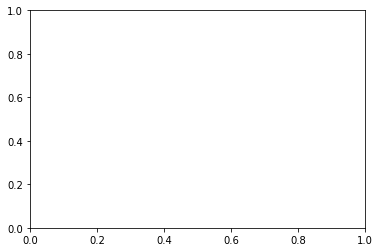

In [58]:
x = len(means)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, means)
plt.xticks(x, params)
plt.show()